In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_coords_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 831)
(772408, 8)
validation
(101248, 831)
(101248, 8)
test
(98888, 831)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1542024 (5.88 MB)


Trainable params: 1542024 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/78 [..............................] - ETA: 1:44 - loss: 2.1569 - STD: 0.0445 - MAE: 0.2200

 5/78 [>.............................] - ETA: 1s - loss: 1.6251 - STD: 0.1361 - MAE: 0.1718  

 9/78 [==>...........................] - ETA: 1s - loss: 1.5086 - STD: 0.1789 - MAE: 0.1534

13/78 [====>.........................] - ETA: 1s - loss: 1.4571 - STD: 0.1809 - MAE: 0.1519

17/78 [=====>........................] - ETA: 0s - loss: 1.4294 - STD: 0.1811 - MAE: 0.1514

19/78 [======>.......................] - ETA: 2s - loss: 1.4201 - STD: 0.1835 - MAE: 0.1501

22/78 [=======>......................] - ETA: 2s - loss: 1.4074 - STD: 0.1878 - MAE: 0.1482

26/78 [=========>....................] - ETA: 2s - loss: 1.3938 - STD: 0.1906 - MAE: 0.1469

29/78 [==========>...................] - ETA: 1s - loss: 1.3862 - STD: 0.1902 - MAE: 0.1469

33/78 [===========>..................] - ETA: 1s - loss: 1.3787 - STD: 0.1890 - MAE: 0.1473

36/78 [============>.................] - ETA: 1s - loss: 1.3736 - STD: 0.1889 - MAE: 0.1472

40/78 [==============>...............] - ETA: 1s - loss: 1.3682 - STD: 0.1898 - MAE: 0.1468

43/78 [===============>..............] - ETA: 1s - loss: 1.3646 - STD: 0.1904 - MAE: 0.1466

46/78 [================>.............] - ETA: 0s - loss: 1.3618 - STD: 0.1905 - MAE: 0.1465

49/78 [=================>............] - ETA: 0s - loss: 1.3591 - STD: 0.1902 - MAE: 0.1466

52/78 [===================>..........] - ETA: 0s - loss: 1.3566 - STD: 0.1900 - MAE: 0.1466

56/78 [====================>.........] - ETA: 0s - loss: 1.3539 - STD: 0.1901 - MAE: 0.1465

59/78 [=====================>........] - ETA: 0s - loss: 1.3518 - STD: 0.1903 - MAE: 0.1464

62/78 [======================>.......] - ETA: 0s - loss: 1.3501 - STD: 0.1903 - MAE: 0.1464

65/78 [========================>.....] - ETA: 0s - loss: 1.3482 - STD: 0.1903 - MAE: 0.1464

68/78 [=========================>....] - ETA: 0s - loss: 1.3468 - STD: 0.1903 - MAE: 0.1463

71/78 [==========================>...] - ETA: 0s - loss: 1.3454 - STD: 0.1903 - MAE: 0.1463

74/78 [===========================>..] - ETA: 0s - loss: 1.3440 - STD: 0.1905 - MAE: 0.1462

77/78 [============================>.] - ETA: 0s - loss: 1.3429 - STD: 0.1905 - MAE: 0.1462

78/78 [==============================] - 4s 34ms/step - loss: 1.3425 - STD: 0.1905 - MAE: 0.1462 - val_loss: 1.2674 - val_STD: 0.1899 - val_MAE: 0.1452


Epoch 2/10000


 1/78 [..............................] - ETA: 3s - loss: 1.3134 - STD: 0.1900 - MAE: 0.1454

 4/78 [>.............................] - ETA: 1s - loss: 1.3178 - STD: 0.1905 - MAE: 0.1456

 7/78 [=>............................] - ETA: 1s - loss: 1.3076 - STD: 0.1910 - MAE: 0.1450

11/78 [===>..........................] - ETA: 1s - loss: 1.3044 - STD: 0.1911 - MAE: 0.1448

15/78 [====>.........................] - ETA: 1s - loss: 1.3047 - STD: 0.1910 - MAE: 0.1449

18/78 [=====>........................] - ETA: 1s - loss: 1.3046 - STD: 0.1909 - MAE: 0.1449

21/78 [=======>......................] - ETA: 0s - loss: 1.3014 - STD: 0.1908 - MAE: 0.1448

25/78 [========>.....................] - ETA: 0s - loss: 1.2985 - STD: 0.1912 - MAE: 0.1444

28/78 [=========>....................] - ETA: 0s - loss: 1.2963 - STD: 0.1915 - MAE: 0.1442

31/78 [==========>...................] - ETA: 0s - loss: 1.2940 - STD: 0.1918 - MAE: 0.1440

34/78 [============>.................] - ETA: 0s - loss: 1.2928 - STD: 0.1919 - MAE: 0.1439

38/78 [=============>................] - ETA: 0s - loss: 1.2889 - STD: 0.1922 - MAE: 0.1436

41/78 [==============>...............] - ETA: 0s - loss: 1.2866 - STD: 0.1925 - MAE: 0.1434

44/78 [===============>..............] - ETA: 0s - loss: 1.2837 - STD: 0.1928 - MAE: 0.1432

47/78 [=================>............] - ETA: 0s - loss: 1.2811 - STD: 0.1930 - MAE: 0.1430

50/78 [==================>...........] - ETA: 0s - loss: 1.2784 - STD: 0.1934 - MAE: 0.1428

54/78 [===================>..........] - ETA: 0s - loss: 1.2740 - STD: 0.1937 - MAE: 0.1425

58/78 [=====================>........] - ETA: 0s - loss: 1.2697 - STD: 0.1940 - MAE: 0.1423

61/78 [======================>.......] - ETA: 0s - loss: 1.2666 - STD: 0.1942 - MAE: 0.1421

64/78 [=======================>......] - ETA: 0s - loss: 1.2632 - STD: 0.1944 - MAE: 0.1420

68/78 [=========================>....] - ETA: 0s - loss: 1.2591 - STD: 0.1948 - MAE: 0.1417

71/78 [==========================>...] - ETA: 0s - loss: 1.2555 - STD: 0.1949 - MAE: 0.1415

74/78 [===========================>..] - ETA: 0s - loss: 1.2523 - STD: 0.1951 - MAE: 0.1414

78/78 [==============================] - ETA: 0s - loss: 1.2483 - STD: 0.1954 - MAE: 0.1411

78/78 [==============================] - 2s 20ms/step - loss: 1.2483 - STD: 0.1954 - MAE: 0.1411 - val_loss: 1.1424 - val_STD: 0.2052 - val_MAE: 0.1349


Epoch 3/10000


 1/78 [..............................] - ETA: 3s - loss: 1.1634 - STD: 0.2038 - MAE: 0.1358

 4/78 [>.............................] - ETA: 1s - loss: 1.1563 - STD: 0.2011 - MAE: 0.1363

 8/78 [==>...........................] - ETA: 1s - loss: 1.1524 - STD: 0.2012 - MAE: 0.1363

12/78 [===>..........................] - ETA: 1s - loss: 1.1474 - STD: 0.2009 - MAE: 0.1362

16/78 [=====>........................] - ETA: 1s - loss: 1.1409 - STD: 0.2016 - MAE: 0.1356

20/78 [======>.......................] - ETA: 0s - loss: 1.1357 - STD: 0.2019 - MAE: 0.1353

24/78 [========>.....................] - ETA: 0s - loss: 1.1298 - STD: 0.2022 - MAE: 0.1350

27/78 [=========>....................] - ETA: 0s - loss: 1.1257 - STD: 0.2021 - MAE: 0.1349

31/78 [==========>...................] - ETA: 0s - loss: 1.1218 - STD: 0.2024 - MAE: 0.1346

35/78 [============>.................] - ETA: 0s - loss: 1.1176 - STD: 0.2027 - MAE: 0.1344

38/78 [=============>................] - ETA: 0s - loss: 1.1150 - STD: 0.2029 - MAE: 0.1342

41/78 [==============>...............] - ETA: 0s - loss: 1.1108 - STD: 0.2031 - MAE: 0.1340

44/78 [===============>..............] - ETA: 0s - loss: 1.1071 - STD: 0.2037 - MAE: 0.1336

47/78 [=================>............] - ETA: 0s - loss: 1.1039 - STD: 0.2039 - MAE: 0.1334

51/78 [==================>...........] - ETA: 0s - loss: 1.1000 - STD: 0.2042 - MAE: 0.1331

54/78 [===================>..........] - ETA: 0s - loss: 1.0967 - STD: 0.2045 - MAE: 0.1329

58/78 [=====================>........] - ETA: 0s - loss: 1.0923 - STD: 0.2050 - MAE: 0.1325

62/78 [======================>.......] - ETA: 0s - loss: 1.0887 - STD: 0.2053 - MAE: 0.1322

65/78 [========================>.....] - ETA: 0s - loss: 1.0852 - STD: 0.2058 - MAE: 0.1319

68/78 [=========================>....] - ETA: 0s - loss: 1.0828 - STD: 0.2060 - MAE: 0.1317

72/78 [==========================>...] - ETA: 0s - loss: 1.0789 - STD: 0.2064 - MAE: 0.1314

75/78 [===========================>..] - ETA: 0s - loss: 1.0760 - STD: 0.2067 - MAE: 0.1311

78/78 [==============================] - 2s 20ms/step - loss: 1.0735 - STD: 0.2070 - MAE: 0.1309 - val_loss: 0.9962 - val_STD: 0.2166 - val_MAE: 0.1238


Epoch 4/10000


 1/78 [..............................] - ETA: 4s - loss: 0.9787 - STD: 0.2201 - MAE: 0.1213

 4/78 [>.............................] - ETA: 1s - loss: 0.9867 - STD: 0.2169 - MAE: 0.1229

 8/78 [==>...........................] - ETA: 1s - loss: 0.9881 - STD: 0.2169 - MAE: 0.1230

11/78 [===>..........................] - ETA: 1s - loss: 0.9889 - STD: 0.2169 - MAE: 0.1229

14/78 [====>.........................] - ETA: 1s - loss: 0.9904 - STD: 0.2170 - MAE: 0.1229

17/78 [=====>........................] - ETA: 1s - loss: 0.9911 - STD: 0.2169 - MAE: 0.1230

21/78 [=======>......................] - ETA: 0s - loss: 0.9896 - STD: 0.2172 - MAE: 0.1228

25/78 [========>.....................] - ETA: 0s - loss: 0.9870 - STD: 0.2173 - MAE: 0.1226

29/78 [==========>...................] - ETA: 0s - loss: 0.9845 - STD: 0.2173 - MAE: 0.1225

32/78 [===========>..................] - ETA: 0s - loss: 0.9833 - STD: 0.2175 - MAE: 0.1224

35/78 [============>.................] - ETA: 0s - loss: 0.9817 - STD: 0.2176 - MAE: 0.1223

38/78 [=============>................] - ETA: 0s - loss: 0.9808 - STD: 0.2177 - MAE: 0.1222

41/78 [==============>...............] - ETA: 0s - loss: 0.9786 - STD: 0.2179 - MAE: 0.1220

44/78 [===============>..............] - ETA: 0s - loss: 0.9768 - STD: 0.2182 - MAE: 0.1218

47/78 [=================>............] - ETA: 0s - loss: 0.9745 - STD: 0.2183 - MAE: 0.1216

50/78 [==================>...........] - ETA: 0s - loss: 0.9727 - STD: 0.2185 - MAE: 0.1215

53/78 [===================>..........] - ETA: 0s - loss: 0.9708 - STD: 0.2187 - MAE: 0.1213

56/78 [====================>.........] - ETA: 0s - loss: 0.9694 - STD: 0.2189 - MAE: 0.1211

59/78 [=====================>........] - ETA: 0s - loss: 0.9678 - STD: 0.2191 - MAE: 0.1210

62/78 [======================>.......] - ETA: 0s - loss: 0.9659 - STD: 0.2192 - MAE: 0.1208

65/78 [========================>.....] - ETA: 0s - loss: 0.9638 - STD: 0.2193 - MAE: 0.1207

68/78 [=========================>....] - ETA: 0s - loss: 0.9620 - STD: 0.2194 - MAE: 0.1206

71/78 [==========================>...] - ETA: 0s - loss: 0.9599 - STD: 0.2195 - MAE: 0.1204

75/78 [===========================>..] - ETA: 0s - loss: 0.9583 - STD: 0.2197 - MAE: 0.1203

78/78 [==============================] - 2s 20ms/step - loss: 0.9566 - STD: 0.2199 - MAE: 0.1201 - val_loss: 0.9078 - val_STD: 0.2244 - val_MAE: 0.1159


Epoch 5/10000


 1/78 [..............................] - ETA: 3s - loss: 0.9008 - STD: 0.2283 - MAE: 0.1139

 4/78 [>.............................] - ETA: 1s - loss: 0.9013 - STD: 0.2256 - MAE: 0.1152

 8/78 [==>...........................] - ETA: 1s - loss: 0.8997 - STD: 0.2260 - MAE: 0.1149

11/78 [===>..........................] - ETA: 1s - loss: 0.8997 - STD: 0.2256 - MAE: 0.1151

14/78 [====>.........................] - ETA: 1s - loss: 0.9014 - STD: 0.2252 - MAE: 0.1154

18/78 [=====>........................] - ETA: 1s - loss: 0.8996 - STD: 0.2258 - MAE: 0.1151

22/78 [=======>......................] - ETA: 0s - loss: 0.8981 - STD: 0.2261 - MAE: 0.1149

26/78 [=========>....................] - ETA: 0s - loss: 0.8967 - STD: 0.2260 - MAE: 0.1149

29/78 [==========>...................] - ETA: 0s - loss: 0.8962 - STD: 0.2260 - MAE: 0.1149

33/78 [===========>..................] - ETA: 0s - loss: 0.8949 - STD: 0.2260 - MAE: 0.1148

37/78 [=============>................] - ETA: 0s - loss: 0.8939 - STD: 0.2264 - MAE: 0.1146

41/78 [==============>...............] - ETA: 0s - loss: 0.8928 - STD: 0.2266 - MAE: 0.1145

44/78 [===============>..............] - ETA: 0s - loss: 0.8921 - STD: 0.2267 - MAE: 0.1144

47/78 [=================>............] - ETA: 0s - loss: 0.8916 - STD: 0.2268 - MAE: 0.1144

51/78 [==================>...........] - ETA: 0s - loss: 0.8904 - STD: 0.2269 - MAE: 0.1143

55/78 [====================>.........] - ETA: 0s - loss: 0.8895 - STD: 0.2269 - MAE: 0.1142

59/78 [=====================>........] - ETA: 0s - loss: 0.8889 - STD: 0.2271 - MAE: 0.1141

63/78 [=======================>......] - ETA: 0s - loss: 0.8884 - STD: 0.2272 - MAE: 0.1140

67/78 [========================>.....] - ETA: 0s - loss: 0.8876 - STD: 0.2274 - MAE: 0.1139

71/78 [==========================>...] - ETA: 0s - loss: 0.8870 - STD: 0.2274 - MAE: 0.1139

74/78 [===========================>..] - ETA: 0s - loss: 0.8864 - STD: 0.2275 - MAE: 0.1139

78/78 [==============================] - ETA: 0s - loss: 0.8853 - STD: 0.2276 - MAE: 0.1138

78/78 [==============================] - 2s 20ms/step - loss: 0.8853 - STD: 0.2276 - MAE: 0.1138 - val_loss: 0.8731 - val_STD: 0.2311 - val_MAE: 0.1115


Epoch 6/10000


 1/78 [..............................] - ETA: 3s - loss: 0.8820 - STD: 0.2348 - MAE: 0.1106

 5/78 [>.............................] - ETA: 1s - loss: 0.8748 - STD: 0.2299 - MAE: 0.1124

 9/78 [==>...........................] - ETA: 1s - loss: 0.8685 - STD: 0.2296 - MAE: 0.1122

12/78 [===>..........................] - ETA: 1s - loss: 0.8639 - STD: 0.2304 - MAE: 0.1116

16/78 [=====>........................] - ETA: 0s - loss: 0.8636 - STD: 0.2306 - MAE: 0.1115

19/78 [======>.......................] - ETA: 0s - loss: 0.8619 - STD: 0.2305 - MAE: 0.1114

22/78 [=======>......................] - ETA: 0s - loss: 0.8628 - STD: 0.2305 - MAE: 0.1114

25/78 [========>.....................] - ETA: 0s - loss: 0.8622 - STD: 0.2306 - MAE: 0.1114

28/78 [=========>....................] - ETA: 0s - loss: 0.8618 - STD: 0.2305 - MAE: 0.1114

31/78 [==========>...................] - ETA: 0s - loss: 0.8615 - STD: 0.2305 - MAE: 0.1114

34/78 [============>.................] - ETA: 0s - loss: 0.8615 - STD: 0.2306 - MAE: 0.1114

37/78 [=============>................] - ETA: 0s - loss: 0.8614 - STD: 0.2306 - MAE: 0.1114

40/78 [==============>...............] - ETA: 0s - loss: 0.8613 - STD: 0.2305 - MAE: 0.1114

43/78 [===============>..............] - ETA: 0s - loss: 0.8609 - STD: 0.2307 - MAE: 0.1113

46/78 [================>.............] - ETA: 0s - loss: 0.8611 - STD: 0.2307 - MAE: 0.1113

50/78 [==================>...........] - ETA: 0s - loss: 0.8608 - STD: 0.2307 - MAE: 0.1113

53/78 [===================>..........] - ETA: 0s - loss: 0.8605 - STD: 0.2308 - MAE: 0.1112

56/78 [====================>.........] - ETA: 0s - loss: 0.8605 - STD: 0.2308 - MAE: 0.1112

60/78 [======================>.......] - ETA: 0s - loss: 0.8593 - STD: 0.2309 - MAE: 0.1111

63/78 [=======================>......] - ETA: 0s - loss: 0.8589 - STD: 0.2309 - MAE: 0.1111

66/78 [========================>.....] - ETA: 0s - loss: 0.8579 - STD: 0.2310 - MAE: 0.1110

70/78 [=========================>....] - ETA: 0s - loss: 0.8573 - STD: 0.2311 - MAE: 0.1109

73/78 [===========================>..] - ETA: 0s - loss: 0.8571 - STD: 0.2311 - MAE: 0.1109

76/78 [============================>.] - ETA: 0s - loss: 0.8567 - STD: 0.2311 - MAE: 0.1109

78/78 [==============================] - 2s 20ms/step - loss: 0.8570 - STD: 0.2313 - MAE: 0.1108 - val_loss: 0.8612 - val_STD: 0.2204 - val_MAE: 0.1161


Epoch 7/10000


 1/78 [..............................] - ETA: 3s - loss: 0.8606 - STD: 0.2236 - MAE: 0.1149

 5/78 [>.............................] - ETA: 1s - loss: 0.8566 - STD: 0.2293 - MAE: 0.1118

 9/78 [==>...........................] - ETA: 1s - loss: 0.8503 - STD: 0.2304 - MAE: 0.1110

12/78 [===>..........................] - ETA: 1s - loss: 0.8517 - STD: 0.2311 - MAE: 0.1108

16/78 [=====>........................] - ETA: 1s - loss: 0.8513 - STD: 0.2315 - MAE: 0.1105

20/78 [======>.......................] - ETA: 0s - loss: 0.8503 - STD: 0.2315 - MAE: 0.1105

24/78 [========>.....................] - ETA: 0s - loss: 0.8479 - STD: 0.2318 - MAE: 0.1102

27/78 [=========>....................] - ETA: 0s - loss: 0.8477 - STD: 0.2323 - MAE: 0.1100

31/78 [==========>...................] - ETA: 0s - loss: 0.8483 - STD: 0.2323 - MAE: 0.1101

34/78 [============>.................] - ETA: 0s - loss: 0.8472 - STD: 0.2325 - MAE: 0.1099

38/78 [=============>................] - ETA: 0s - loss: 0.8470 - STD: 0.2325 - MAE: 0.1099

42/78 [===============>..............] - ETA: 0s - loss: 0.8463 - STD: 0.2326 - MAE: 0.1098

45/78 [================>.............] - ETA: 0s - loss: 0.8469 - STD: 0.2325 - MAE: 0.1099

48/78 [=================>............] - ETA: 0s - loss: 0.8457 - STD: 0.2324 - MAE: 0.1099

52/78 [===================>..........] - ETA: 0s - loss: 0.8451 - STD: 0.2326 - MAE: 0.1098

56/78 [====================>.........] - ETA: 0s - loss: 0.8448 - STD: 0.2326 - MAE: 0.1098

60/78 [======================>.......] - ETA: 0s - loss: 0.8444 - STD: 0.2326 - MAE: 0.1097

64/78 [=======================>......] - ETA: 0s - loss: 0.8436 - STD: 0.2328 - MAE: 0.1096

67/78 [========================>.....] - ETA: 0s - loss: 0.8429 - STD: 0.2327 - MAE: 0.1096

71/78 [==========================>...] - ETA: 0s - loss: 0.8422 - STD: 0.2328 - MAE: 0.1095

74/78 [===========================>..] - ETA: 0s - loss: 0.8420 - STD: 0.2328 - MAE: 0.1095

78/78 [==============================] - ETA: 0s - loss: 0.8414 - STD: 0.2329 - MAE: 0.1095

78/78 [==============================] - 2s 19ms/step - loss: 0.8414 - STD: 0.2329 - MAE: 0.1095 - val_loss: 0.8317 - val_STD: 0.2310 - val_MAE: 0.1097


Epoch 8/10000


 1/78 [..............................] - ETA: 3s - loss: 0.8361 - STD: 0.2340 - MAE: 0.1087

 4/78 [>.............................] - ETA: 1s - loss: 0.8312 - STD: 0.2339 - MAE: 0.1085

 8/78 [==>...........................] - ETA: 1s - loss: 0.8312 - STD: 0.2339 - MAE: 0.1085

12/78 [===>..........................] - ETA: 1s - loss: 0.8298 - STD: 0.2340 - MAE: 0.1084

15/78 [====>.........................] - ETA: 1s - loss: 0.8293 - STD: 0.2339 - MAE: 0.1084

18/78 [=====>........................] - ETA: 0s - loss: 0.8281 - STD: 0.2343 - MAE: 0.1083

21/78 [=======>......................] - ETA: 0s - loss: 0.8259 - STD: 0.2345 - MAE: 0.1080

24/78 [========>.....................] - ETA: 0s - loss: 0.8250 - STD: 0.2346 - MAE: 0.1079

27/78 [=========>....................] - ETA: 0s - loss: 0.8242 - STD: 0.2346 - MAE: 0.1079

31/78 [==========>...................] - ETA: 0s - loss: 0.8233 - STD: 0.2345 - MAE: 0.1078

34/78 [============>.................] - ETA: 0s - loss: 0.8240 - STD: 0.2346 - MAE: 0.1078

37/78 [=============>................] - ETA: 0s - loss: 0.8255 - STD: 0.2348 - MAE: 0.1078

41/78 [==============>...............] - ETA: 0s - loss: 0.8259 - STD: 0.2348 - MAE: 0.1078

44/78 [===============>..............] - ETA: 0s - loss: 0.8269 - STD: 0.2350 - MAE: 0.1078

47/78 [=================>............] - ETA: 0s - loss: 0.8268 - STD: 0.2349 - MAE: 0.1078

50/78 [==================>...........] - ETA: 0s - loss: 0.8268 - STD: 0.2347 - MAE: 0.1079

53/78 [===================>..........] - ETA: 0s - loss: 0.8258 - STD: 0.2348 - MAE: 0.1078

56/78 [====================>.........] - ETA: 0s - loss: 0.8250 - STD: 0.2348 - MAE: 0.1078

59/78 [=====================>........] - ETA: 0s - loss: 0.8244 - STD: 0.2348 - MAE: 0.1078

62/78 [======================>.......] - ETA: 0s - loss: 0.8241 - STD: 0.2348 - MAE: 0.1078

66/78 [========================>.....] - ETA: 0s - loss: 0.8236 - STD: 0.2348 - MAE: 0.1077

70/78 [=========================>....] - ETA: 0s - loss: 0.8229 - STD: 0.2349 - MAE: 0.1077

74/78 [===========================>..] - ETA: 0s - loss: 0.8223 - STD: 0.2350 - MAE: 0.1076

78/78 [==============================] - ETA: 0s - loss: 0.8222 - STD: 0.2350 - MAE: 0.1076

78/78 [==============================] - 2s 20ms/step - loss: 0.8222 - STD: 0.2350 - MAE: 0.1076 - val_loss: 0.8060 - val_STD: 0.2287 - val_MAE: 0.1101


Epoch 9/10000


 1/78 [..............................] - ETA: 3s - loss: 0.8101 - STD: 0.2332 - MAE: 0.1077

 5/78 [>.............................] - ETA: 1s - loss: 0.8163 - STD: 0.2345 - MAE: 0.1076

 9/78 [==>...........................] - ETA: 1s - loss: 0.8129 - STD: 0.2346 - MAE: 0.1074

12/78 [===>..........................] - ETA: 1s - loss: 0.8132 - STD: 0.2352 - MAE: 0.1071

16/78 [=====>........................] - ETA: 1s - loss: 0.8147 - STD: 0.2353 - MAE: 0.1072

19/78 [======>.......................] - ETA: 0s - loss: 0.8135 - STD: 0.2354 - MAE: 0.1070

22/78 [=======>......................] - ETA: 0s - loss: 0.8136 - STD: 0.2356 - MAE: 0.1069

25/78 [========>.....................] - ETA: 0s - loss: 0.8153 - STD: 0.2358 - MAE: 0.1070

28/78 [=========>....................] - ETA: 0s - loss: 0.8151 - STD: 0.2359 - MAE: 0.1069

31/78 [==========>...................] - ETA: 0s - loss: 0.8151 - STD: 0.2358 - MAE: 0.1069

35/78 [============>.................] - ETA: 0s - loss: 0.8149 - STD: 0.2359 - MAE: 0.1069

38/78 [=============>................] - ETA: 0s - loss: 0.8144 - STD: 0.2359 - MAE: 0.1069

41/78 [==============>...............] - ETA: 0s - loss: 0.8143 - STD: 0.2357 - MAE: 0.1070

45/78 [================>.............] - ETA: 0s - loss: 0.8142 - STD: 0.2358 - MAE: 0.1069

49/78 [=================>............] - ETA: 0s - loss: 0.8136 - STD: 0.2359 - MAE: 0.1069

52/78 [===================>..........] - ETA: 0s - loss: 0.8130 - STD: 0.2358 - MAE: 0.1069

55/78 [====================>.........] - ETA: 0s - loss: 0.8121 - STD: 0.2358 - MAE: 0.1068

58/78 [=====================>........] - ETA: 0s - loss: 0.8110 - STD: 0.2359 - MAE: 0.1067

61/78 [======================>.......] - ETA: 0s - loss: 0.8103 - STD: 0.2360 - MAE: 0.1066

64/78 [=======================>......] - ETA: 0s - loss: 0.8101 - STD: 0.2360 - MAE: 0.1066

67/78 [========================>.....] - ETA: 0s - loss: 0.8097 - STD: 0.2362 - MAE: 0.1065

70/78 [=========================>....] - ETA: 0s - loss: 0.8094 - STD: 0.2362 - MAE: 0.1065

73/78 [===========================>..] - ETA: 0s - loss: 0.8086 - STD: 0.2363 - MAE: 0.1064

76/78 [============================>.] - ETA: 0s - loss: 0.8081 - STD: 0.2363 - MAE: 0.1063

78/78 [==============================] - 2s 19ms/step - loss: 0.8078 - STD: 0.2363 - MAE: 0.1063 - val_loss: 0.8204 - val_STD: 0.2381 - val_MAE: 0.1059


Epoch 10/10000


 1/78 [..............................] - ETA: 3s - loss: 0.8022 - STD: 0.2410 - MAE: 0.1039

 4/78 [>.............................] - ETA: 1s - loss: 0.8033 - STD: 0.2387 - MAE: 0.1051

 8/78 [==>...........................] - ETA: 1s - loss: 0.8022 - STD: 0.2382 - MAE: 0.1052

11/78 [===>..........................] - ETA: 1s - loss: 0.8024 - STD: 0.2377 - MAE: 0.1055

15/78 [====>.........................] - ETA: 1s - loss: 0.7994 - STD: 0.2374 - MAE: 0.1055

18/78 [=====>........................] - ETA: 1s - loss: 0.7988 - STD: 0.2373 - MAE: 0.1055

22/78 [=======>......................] - ETA: 0s - loss: 0.7984 - STD: 0.2377 - MAE: 0.1053

25/78 [========>.....................] - ETA: 0s - loss: 0.7986 - STD: 0.2376 - MAE: 0.1054

29/78 [==========>...................] - ETA: 0s - loss: 0.7976 - STD: 0.2376 - MAE: 0.1052

32/78 [===========>..................] - ETA: 0s - loss: 0.7986 - STD: 0.2376 - MAE: 0.1053

36/78 [============>.................] - ETA: 0s - loss: 0.7977 - STD: 0.2376 - MAE: 0.1052

40/78 [==============>...............] - ETA: 0s - loss: 0.7982 - STD: 0.2375 - MAE: 0.1053

44/78 [===============>..............] - ETA: 0s - loss: 0.7974 - STD: 0.2378 - MAE: 0.1052

48/78 [=================>............] - ETA: 0s - loss: 0.7978 - STD: 0.2378 - MAE: 0.1052

52/78 [===================>..........] - ETA: 0s - loss: 0.7984 - STD: 0.2377 - MAE: 0.1053

56/78 [====================>.........] - ETA: 0s - loss: 0.7985 - STD: 0.2376 - MAE: 0.1053

60/78 [======================>.......] - ETA: 0s - loss: 0.7980 - STD: 0.2376 - MAE: 0.1053

63/78 [=======================>......] - ETA: 0s - loss: 0.7977 - STD: 0.2376 - MAE: 0.1053

66/78 [========================>.....] - ETA: 0s - loss: 0.7970 - STD: 0.2376 - MAE: 0.1052

70/78 [=========================>....] - ETA: 0s - loss: 0.7965 - STD: 0.2377 - MAE: 0.1052

74/78 [===========================>..] - ETA: 0s - loss: 0.7957 - STD: 0.2377 - MAE: 0.1051

78/78 [==============================] - ETA: 0s - loss: 0.7945 - STD: 0.2378 - MAE: 0.1050

78/78 [==============================] - 2s 19ms/step - loss: 0.7945 - STD: 0.2378 - MAE: 0.1050 - val_loss: 0.7861 - val_STD: 0.2375 - val_MAE: 0.1056


Epoch 11/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7971 - STD: 0.2407 - MAE: 0.1038

 4/78 [>.............................] - ETA: 1s - loss: 0.7974 - STD: 0.2384 - MAE: 0.1048

 7/78 [=>............................] - ETA: 1s - loss: 0.7945 - STD: 0.2388 - MAE: 0.1046

10/78 [==>...........................] - ETA: 1s - loss: 0.7868 - STD: 0.2393 - MAE: 0.1040

14/78 [====>.........................] - ETA: 1s - loss: 0.7882 - STD: 0.2390 - MAE: 0.1043

18/78 [=====>........................] - ETA: 0s - loss: 0.7900 - STD: 0.2388 - MAE: 0.1044

21/78 [=======>......................] - ETA: 0s - loss: 0.7889 - STD: 0.2388 - MAE: 0.1044

25/78 [========>.....................] - ETA: 0s - loss: 0.7883 - STD: 0.2388 - MAE: 0.1044

29/78 [==========>...................] - ETA: 0s - loss: 0.7869 - STD: 0.2387 - MAE: 0.1043

32/78 [===========>..................] - ETA: 0s - loss: 0.7874 - STD: 0.2386 - MAE: 0.1044

36/78 [============>.................] - ETA: 0s - loss: 0.7864 - STD: 0.2386 - MAE: 0.1044

39/78 [==============>...............] - ETA: 0s - loss: 0.7865 - STD: 0.2386 - MAE: 0.1044

42/78 [===============>..............] - ETA: 0s - loss: 0.7863 - STD: 0.2387 - MAE: 0.1043

46/78 [================>.............] - ETA: 0s - loss: 0.7852 - STD: 0.2387 - MAE: 0.1042

50/78 [==================>...........] - ETA: 0s - loss: 0.7846 - STD: 0.2388 - MAE: 0.1042

53/78 [===================>..........] - ETA: 0s - loss: 0.7835 - STD: 0.2388 - MAE: 0.1041

57/78 [====================>.........] - ETA: 0s - loss: 0.7828 - STD: 0.2389 - MAE: 0.1040

61/78 [======================>.......] - ETA: 0s - loss: 0.7825 - STD: 0.2389 - MAE: 0.1040

65/78 [========================>.....] - ETA: 0s - loss: 0.7834 - STD: 0.2390 - MAE: 0.1040

69/78 [=========================>....] - ETA: 0s - loss: 0.7832 - STD: 0.2391 - MAE: 0.1039

72/78 [==========================>...] - ETA: 0s - loss: 0.7826 - STD: 0.2391 - MAE: 0.1039

76/78 [============================>.] - ETA: 0s - loss: 0.7823 - STD: 0.2391 - MAE: 0.1039

78/78 [==============================] - 2s 19ms/step - loss: 0.7822 - STD: 0.2391 - MAE: 0.1039 - val_loss: 0.7660 - val_STD: 0.2339 - val_MAE: 0.1066


Epoch 12/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7777 - STD: 0.2362 - MAE: 0.1052

 4/78 [>.............................] - ETA: 1s - loss: 0.7659 - STD: 0.2390 - MAE: 0.1031

 8/78 [==>...........................] - ETA: 1s - loss: 0.7702 - STD: 0.2394 - MAE: 0.1032

11/78 [===>..........................] - ETA: 1s - loss: 0.7777 - STD: 0.2396 - MAE: 0.1035

14/78 [====>.........................] - ETA: 1s - loss: 0.7786 - STD: 0.2399 - MAE: 0.1034

18/78 [=====>........................] - ETA: 1s - loss: 0.7782 - STD: 0.2396 - MAE: 0.1035

21/78 [=======>......................] - ETA: 0s - loss: 0.7776 - STD: 0.2395 - MAE: 0.1035

24/78 [========>.....................] - ETA: 0s - loss: 0.7771 - STD: 0.2393 - MAE: 0.1036

27/78 [=========>....................] - ETA: 0s - loss: 0.7770 - STD: 0.2393 - MAE: 0.1036

30/78 [==========>...................] - ETA: 0s - loss: 0.7761 - STD: 0.2395 - MAE: 0.1035

33/78 [===========>..................] - ETA: 0s - loss: 0.7754 - STD: 0.2395 - MAE: 0.1034

37/78 [=============>................] - ETA: 0s - loss: 0.7737 - STD: 0.2396 - MAE: 0.1033

40/78 [==============>...............] - ETA: 0s - loss: 0.7725 - STD: 0.2397 - MAE: 0.1032

44/78 [===============>..............] - ETA: 0s - loss: 0.7728 - STD: 0.2398 - MAE: 0.1032

47/78 [=================>............] - ETA: 0s - loss: 0.7724 - STD: 0.2398 - MAE: 0.1031

51/78 [==================>...........] - ETA: 0s - loss: 0.7720 - STD: 0.2398 - MAE: 0.1031

54/78 [===================>..........] - ETA: 0s - loss: 0.7713 - STD: 0.2399 - MAE: 0.1031

58/78 [=====================>........] - ETA: 0s - loss: 0.7715 - STD: 0.2399 - MAE: 0.1030

61/78 [======================>.......] - ETA: 0s - loss: 0.7725 - STD: 0.2400 - MAE: 0.1031

65/78 [========================>.....] - ETA: 0s - loss: 0.7727 - STD: 0.2401 - MAE: 0.1031

68/78 [=========================>....] - ETA: 0s - loss: 0.7727 - STD: 0.2401 - MAE: 0.1030

72/78 [==========================>...] - ETA: 0s - loss: 0.7731 - STD: 0.2400 - MAE: 0.1031

75/78 [===========================>..] - ETA: 0s - loss: 0.7729 - STD: 0.2400 - MAE: 0.1031

78/78 [==============================] - 2s 19ms/step - loss: 0.7727 - STD: 0.2400 - MAE: 0.1031 - val_loss: 0.7819 - val_STD: 0.2364 - val_MAE: 0.1056


Epoch 13/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7688 - STD: 0.2407 - MAE: 0.1026

 4/78 [>.............................] - ETA: 1s - loss: 0.7660 - STD: 0.2412 - MAE: 0.1020

 7/78 [=>............................] - ETA: 1s - loss: 0.7659 - STD: 0.2411 - MAE: 0.1022

11/78 [===>..........................] - ETA: 1s - loss: 0.7696 - STD: 0.2410 - MAE: 0.1024

14/78 [====>.........................] - ETA: 1s - loss: 0.7694 - STD: 0.2410 - MAE: 0.1025

18/78 [=====>........................] - ETA: 1s - loss: 0.7697 - STD: 0.2408 - MAE: 0.1026

22/78 [=======>......................] - ETA: 0s - loss: 0.7767 - STD: 0.2405 - MAE: 0.1030

25/78 [========>.....................] - ETA: 0s - loss: 0.7810 - STD: 0.2409 - MAE: 0.1031

29/78 [==========>...................] - ETA: 0s - loss: 0.7821 - STD: 0.2407 - MAE: 0.1032

33/78 [===========>..................] - ETA: 0s - loss: 0.7821 - STD: 0.2405 - MAE: 0.1033

36/78 [============>.................] - ETA: 0s - loss: 0.7814 - STD: 0.2403 - MAE: 0.1033

40/78 [==============>...............] - ETA: 0s - loss: 0.7795 - STD: 0.2403 - MAE: 0.1033

43/78 [===============>..............] - ETA: 0s - loss: 0.7783 - STD: 0.2403 - MAE: 0.1032

46/78 [================>.............] - ETA: 0s - loss: 0.7780 - STD: 0.2402 - MAE: 0.1033

49/78 [=================>............] - ETA: 0s - loss: 0.7766 - STD: 0.2403 - MAE: 0.1032

52/78 [===================>..........] - ETA: 0s - loss: 0.7761 - STD: 0.2403 - MAE: 0.1032

55/78 [====================>.........] - ETA: 0s - loss: 0.7752 - STD: 0.2402 - MAE: 0.1031

59/78 [=====================>........] - ETA: 0s - loss: 0.7742 - STD: 0.2403 - MAE: 0.1030

62/78 [======================>.......] - ETA: 0s - loss: 0.7731 - STD: 0.2403 - MAE: 0.1030

65/78 [========================>.....] - ETA: 0s - loss: 0.7724 - STD: 0.2402 - MAE: 0.1030

68/78 [=========================>....] - ETA: 0s - loss: 0.7719 - STD: 0.2403 - MAE: 0.1029

72/78 [==========================>...] - ETA: 0s - loss: 0.7704 - STD: 0.2403 - MAE: 0.1029

75/78 [===========================>..] - ETA: 0s - loss: 0.7694 - STD: 0.2403 - MAE: 0.1028

78/78 [==============================] - 2s 20ms/step - loss: 0.7688 - STD: 0.2404 - MAE: 0.1027 - val_loss: 0.7618 - val_STD: 0.2369 - val_MAE: 0.1048


Epoch 14/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7515 - STD: 0.2405 - MAE: 0.1021

 4/78 [>.............................] - ETA: 1s - loss: 0.7520 - STD: 0.2408 - MAE: 0.1018

 8/78 [==>...........................] - ETA: 1s - loss: 0.7511 - STD: 0.2414 - MAE: 0.1015

11/78 [===>..........................] - ETA: 1s - loss: 0.7510 - STD: 0.2414 - MAE: 0.1014

14/78 [====>.........................] - ETA: 1s - loss: 0.7528 - STD: 0.2411 - MAE: 0.1017

17/78 [=====>........................] - ETA: 1s - loss: 0.7529 - STD: 0.2412 - MAE: 0.1017

20/78 [======>.......................] - ETA: 0s - loss: 0.7550 - STD: 0.2412 - MAE: 0.1018

23/78 [=======>......................] - ETA: 0s - loss: 0.7547 - STD: 0.2412 - MAE: 0.1017

27/78 [=========>....................] - ETA: 0s - loss: 0.7540 - STD: 0.2412 - MAE: 0.1017

31/78 [==========>...................] - ETA: 0s - loss: 0.7540 - STD: 0.2414 - MAE: 0.1016

34/78 [============>.................] - ETA: 0s - loss: 0.7536 - STD: 0.2416 - MAE: 0.1014

37/78 [=============>................] - ETA: 0s - loss: 0.7534 - STD: 0.2418 - MAE: 0.1013

41/78 [==============>...............] - ETA: 0s - loss: 0.7534 - STD: 0.2417 - MAE: 0.1013

44/78 [===============>..............] - ETA: 0s - loss: 0.7536 - STD: 0.2418 - MAE: 0.1013

47/78 [=================>............] - ETA: 0s - loss: 0.7540 - STD: 0.2417 - MAE: 0.1013

50/78 [==================>...........] - ETA: 0s - loss: 0.7538 - STD: 0.2416 - MAE: 0.1014

54/78 [===================>..........] - ETA: 0s - loss: 0.7534 - STD: 0.2417 - MAE: 0.1013

57/78 [====================>.........] - ETA: 0s - loss: 0.7537 - STD: 0.2417 - MAE: 0.1013

60/78 [======================>.......] - ETA: 0s - loss: 0.7549 - STD: 0.2418 - MAE: 0.1014

63/78 [=======================>......] - ETA: 0s - loss: 0.7558 - STD: 0.2418 - MAE: 0.1014

66/78 [========================>.....] - ETA: 0s - loss: 0.7559 - STD: 0.2418 - MAE: 0.1014

69/78 [=========================>....] - ETA: 0s - loss: 0.7556 - STD: 0.2418 - MAE: 0.1014

72/78 [==========================>...] - ETA: 0s - loss: 0.7560 - STD: 0.2418 - MAE: 0.1014

76/78 [============================>.] - ETA: 0s - loss: 0.7557 - STD: 0.2418 - MAE: 0.1014

78/78 [==============================] - 2s 20ms/step - loss: 0.7554 - STD: 0.2418 - MAE: 0.1014 - val_loss: 0.7469 - val_STD: 0.2399 - val_MAE: 0.1027


Epoch 15/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7552 - STD: 0.2436 - MAE: 0.1008

 4/78 [>.............................] - ETA: 1s - loss: 0.7551 - STD: 0.2412 - MAE: 0.1017

 8/78 [==>...........................] - ETA: 1s - loss: 0.7520 - STD: 0.2416 - MAE: 0.1014

12/78 [===>..........................] - ETA: 1s - loss: 0.7505 - STD: 0.2420 - MAE: 0.1011

16/78 [=====>........................] - ETA: 0s - loss: 0.7513 - STD: 0.2417 - MAE: 0.1013

20/78 [======>.......................] - ETA: 0s - loss: 0.7513 - STD: 0.2421 - MAE: 0.1011

23/78 [=======>......................] - ETA: 0s - loss: 0.7501 - STD: 0.2420 - MAE: 0.1011

26/78 [=========>....................] - ETA: 0s - loss: 0.7505 - STD: 0.2420 - MAE: 0.1012

30/78 [==========>...................] - ETA: 0s - loss: 0.7497 - STD: 0.2419 - MAE: 0.1011

34/78 [============>.................] - ETA: 0s - loss: 0.7490 - STD: 0.2420 - MAE: 0.1011

38/78 [=============>................] - ETA: 0s - loss: 0.7482 - STD: 0.2420 - MAE: 0.1010

42/78 [===============>..............] - ETA: 0s - loss: 0.7476 - STD: 0.2420 - MAE: 0.1010

46/78 [================>.............] - ETA: 0s - loss: 0.7475 - STD: 0.2419 - MAE: 0.1011

50/78 [==================>...........] - ETA: 0s - loss: 0.7485 - STD: 0.2418 - MAE: 0.1011

54/78 [===================>..........] - ETA: 0s - loss: 0.7487 - STD: 0.2420 - MAE: 0.1011

58/78 [=====================>........] - ETA: 0s - loss: 0.7498 - STD: 0.2420 - MAE: 0.1011

62/78 [======================>.......] - ETA: 0s - loss: 0.7499 - STD: 0.2422 - MAE: 0.1010

66/78 [========================>.....] - ETA: 0s - loss: 0.7494 - STD: 0.2423 - MAE: 0.1009

70/78 [=========================>....] - ETA: 0s - loss: 0.7497 - STD: 0.2423 - MAE: 0.1009

74/78 [===========================>..] - ETA: 0s - loss: 0.7496 - STD: 0.2422 - MAE: 0.1010

78/78 [==============================] - ETA: 0s - loss: 0.7491 - STD: 0.2423 - MAE: 0.1009

78/78 [==============================] - 1s 19ms/step - loss: 0.7491 - STD: 0.2423 - MAE: 0.1009 - val_loss: 0.7600 - val_STD: 0.2322 - val_MAE: 0.1070


Epoch 16/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7237 - STD: 0.2379 - MAE: 0.1017

 4/78 [>.............................] - ETA: 1s - loss: 0.7329 - STD: 0.2413 - MAE: 0.1004

 7/78 [=>............................] - ETA: 1s - loss: 0.7378 - STD: 0.2424 - MAE: 0.1002

11/78 [===>..........................] - ETA: 1s - loss: 0.7396 - STD: 0.2423 - MAE: 0.1004

14/78 [====>.........................] - ETA: 1s - loss: 0.7414 - STD: 0.2423 - MAE: 0.1006

17/78 [=====>........................] - ETA: 1s - loss: 0.7430 - STD: 0.2424 - MAE: 0.1006

21/78 [=======>......................] - ETA: 0s - loss: 0.7461 - STD: 0.2421 - MAE: 0.1009

24/78 [========>.....................] - ETA: 0s - loss: 0.7466 - STD: 0.2424 - MAE: 0.1008

27/78 [=========>....................] - ETA: 0s - loss: 0.7478 - STD: 0.2426 - MAE: 0.1008

30/78 [==========>...................] - ETA: 0s - loss: 0.7487 - STD: 0.2424 - MAE: 0.1009

33/78 [===========>..................] - ETA: 0s - loss: 0.7491 - STD: 0.2424 - MAE: 0.1009

36/78 [============>.................] - ETA: 0s - loss: 0.7488 - STD: 0.2425 - MAE: 0.1009

39/78 [==============>...............] - ETA: 0s - loss: 0.7493 - STD: 0.2425 - MAE: 0.1009

43/78 [===============>..............] - ETA: 0s - loss: 0.7497 - STD: 0.2424 - MAE: 0.1009

47/78 [=================>............] - ETA: 0s - loss: 0.7489 - STD: 0.2426 - MAE: 0.1008

50/78 [==================>...........] - ETA: 0s - loss: 0.7485 - STD: 0.2426 - MAE: 0.1007

53/78 [===================>..........] - ETA: 0s - loss: 0.7480 - STD: 0.2426 - MAE: 0.1007

57/78 [====================>.........] - ETA: 0s - loss: 0.7476 - STD: 0.2426 - MAE: 0.1007

60/78 [======================>.......] - ETA: 0s - loss: 0.7466 - STD: 0.2426 - MAE: 0.1006

64/78 [=======================>......] - ETA: 0s - loss: 0.7454 - STD: 0.2426 - MAE: 0.1006

67/78 [========================>.....] - ETA: 0s - loss: 0.7449 - STD: 0.2426 - MAE: 0.1006

71/78 [==========================>...] - ETA: 0s - loss: 0.7440 - STD: 0.2427 - MAE: 0.1005

75/78 [===========================>..] - ETA: 0s - loss: 0.7436 - STD: 0.2427 - MAE: 0.1004

78/78 [==============================] - 2s 19ms/step - loss: 0.7431 - STD: 0.2427 - MAE: 0.1004 - val_loss: 0.7421 - val_STD: 0.2427 - val_MAE: 0.1013


Epoch 17/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7471 - STD: 0.2457 - MAE: 0.0995

 4/78 [>.............................] - ETA: 1s - loss: 0.7421 - STD: 0.2436 - MAE: 0.1001

 8/78 [==>...........................] - ETA: 1s - loss: 0.7401 - STD: 0.2428 - MAE: 0.1003

12/78 [===>..........................] - ETA: 1s - loss: 0.7391 - STD: 0.2429 - MAE: 0.1002

15/78 [====>.........................] - ETA: 1s - loss: 0.7386 - STD: 0.2429 - MAE: 0.1002

18/78 [=====>........................] - ETA: 1s - loss: 0.7398 - STD: 0.2428 - MAE: 0.1003

21/78 [=======>......................] - ETA: 0s - loss: 0.7390 - STD: 0.2432 - MAE: 0.1001

25/78 [========>.....................] - ETA: 0s - loss: 0.7394 - STD: 0.2432 - MAE: 0.1001

28/78 [=========>....................] - ETA: 0s - loss: 0.7408 - STD: 0.2432 - MAE: 0.1002

31/78 [==========>...................] - ETA: 0s - loss: 0.7420 - STD: 0.2434 - MAE: 0.1002

35/78 [============>.................] - ETA: 0s - loss: 0.7420 - STD: 0.2432 - MAE: 0.1003

39/78 [==============>...............] - ETA: 0s - loss: 0.7412 - STD: 0.2431 - MAE: 0.1003

43/78 [===============>..............] - ETA: 0s - loss: 0.7412 - STD: 0.2430 - MAE: 0.1003

46/78 [================>.............] - ETA: 0s - loss: 0.7409 - STD: 0.2431 - MAE: 0.1002

50/78 [==================>...........] - ETA: 0s - loss: 0.7406 - STD: 0.2430 - MAE: 0.1003

53/78 [===================>..........] - ETA: 0s - loss: 0.7396 - STD: 0.2431 - MAE: 0.1002

56/78 [====================>.........] - ETA: 0s - loss: 0.7389 - STD: 0.2432 - MAE: 0.1001

59/78 [=====================>........] - ETA: 0s - loss: 0.7384 - STD: 0.2432 - MAE: 0.1000

62/78 [======================>.......] - ETA: 0s - loss: 0.7382 - STD: 0.2432 - MAE: 0.1000

65/78 [========================>.....] - ETA: 0s - loss: 0.7381 - STD: 0.2433 - MAE: 0.1000

68/78 [=========================>....] - ETA: 0s - loss: 0.7379 - STD: 0.2434 - MAE: 0.0999

71/78 [==========================>...] - ETA: 0s - loss: 0.7371 - STD: 0.2434 - MAE: 0.0999

74/78 [===========================>..] - ETA: 0s - loss: 0.7364 - STD: 0.2434 - MAE: 0.0998

78/78 [==============================] - ETA: 0s - loss: 0.7357 - STD: 0.2435 - MAE: 0.0997

78/78 [==============================] - 2s 20ms/step - loss: 0.7357 - STD: 0.2435 - MAE: 0.0997 - val_loss: 0.7363 - val_STD: 0.2377 - val_MAE: 0.1034


Epoch 18/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7206 - STD: 0.2428 - MAE: 0.0990

 4/78 [>.............................] - ETA: 1s - loss: 0.7229 - STD: 0.2443 - MAE: 0.0986

 7/78 [=>............................] - ETA: 1s - loss: 0.7223 - STD: 0.2443 - MAE: 0.0985

11/78 [===>..........................] - ETA: 1s - loss: 0.7225 - STD: 0.2441 - MAE: 0.0987

15/78 [====>.........................] - ETA: 1s - loss: 0.7242 - STD: 0.2439 - MAE: 0.0988

18/78 [=====>........................] - ETA: 1s - loss: 0.7235 - STD: 0.2439 - MAE: 0.0988

21/78 [=======>......................] - ETA: 0s - loss: 0.7232 - STD: 0.2441 - MAE: 0.0987

24/78 [========>.....................] - ETA: 0s - loss: 0.7249 - STD: 0.2439 - MAE: 0.0989

28/78 [=========>....................] - ETA: 0s - loss: 0.7250 - STD: 0.2440 - MAE: 0.0988

31/78 [==========>...................] - ETA: 0s - loss: 0.7252 - STD: 0.2440 - MAE: 0.0989

34/78 [============>.................] - ETA: 0s - loss: 0.7267 - STD: 0.2441 - MAE: 0.0989

37/78 [=============>................] - ETA: 0s - loss: 0.7289 - STD: 0.2442 - MAE: 0.0990

40/78 [==============>...............] - ETA: 0s - loss: 0.7288 - STD: 0.2442 - MAE: 0.0990

44/78 [===============>..............] - ETA: 0s - loss: 0.7291 - STD: 0.2442 - MAE: 0.0990

48/78 [=================>............] - ETA: 0s - loss: 0.7295 - STD: 0.2441 - MAE: 0.0991

51/78 [==================>...........] - ETA: 0s - loss: 0.7303 - STD: 0.2441 - MAE: 0.0991

54/78 [===================>..........] - ETA: 0s - loss: 0.7308 - STD: 0.2441 - MAE: 0.0991

57/78 [====================>.........] - ETA: 0s - loss: 0.7306 - STD: 0.2442 - MAE: 0.0991

60/78 [======================>.......] - ETA: 0s - loss: 0.7303 - STD: 0.2442 - MAE: 0.0991

63/78 [=======================>......] - ETA: 0s - loss: 0.7302 - STD: 0.2442 - MAE: 0.0991

66/78 [========================>.....] - ETA: 0s - loss: 0.7300 - STD: 0.2441 - MAE: 0.0991

69/78 [=========================>....] - ETA: 0s - loss: 0.7295 - STD: 0.2442 - MAE: 0.0991

72/78 [==========================>...] - ETA: 0s - loss: 0.7291 - STD: 0.2442 - MAE: 0.0990

75/78 [===========================>..] - ETA: 0s - loss: 0.7285 - STD: 0.2442 - MAE: 0.0990

78/78 [==============================] - 2s 20ms/step - loss: 0.7284 - STD: 0.2442 - MAE: 0.0990 - val_loss: 0.7277 - val_STD: 0.2365 - val_MAE: 0.1040


Epoch 19/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7286 - STD: 0.2395 - MAE: 0.1014

 5/78 [>.............................] - ETA: 1s - loss: 0.7364 - STD: 0.2441 - MAE: 0.0993

 9/78 [==>...........................] - ETA: 1s - loss: 0.7398 - STD: 0.2442 - MAE: 0.0995

12/78 [===>..........................] - ETA: 1s - loss: 0.7374 - STD: 0.2445 - MAE: 0.0992

15/78 [====>.........................] - ETA: 1s - loss: 0.7373 - STD: 0.2448 - MAE: 0.0991

18/78 [=====>........................] - ETA: 1s - loss: 0.7368 - STD: 0.2446 - MAE: 0.0992

21/78 [=======>......................] - ETA: 0s - loss: 0.7370 - STD: 0.2440 - MAE: 0.0995

24/78 [========>.....................] - ETA: 0s - loss: 0.7360 - STD: 0.2441 - MAE: 0.0994

27/78 [=========>....................] - ETA: 0s - loss: 0.7349 - STD: 0.2443 - MAE: 0.0993

30/78 [==========>...................] - ETA: 0s - loss: 0.7349 - STD: 0.2443 - MAE: 0.0993

34/78 [============>.................] - ETA: 0s - loss: 0.7338 - STD: 0.2443 - MAE: 0.0992

37/78 [=============>................] - ETA: 0s - loss: 0.7326 - STD: 0.2443 - MAE: 0.0992

40/78 [==============>...............] - ETA: 0s - loss: 0.7316 - STD: 0.2442 - MAE: 0.0992

43/78 [===============>..............] - ETA: 0s - loss: 0.7311 - STD: 0.2444 - MAE: 0.0991

46/78 [================>.............] - ETA: 0s - loss: 0.7305 - STD: 0.2443 - MAE: 0.0991

50/78 [==================>...........] - ETA: 0s - loss: 0.7291 - STD: 0.2444 - MAE: 0.0990

53/78 [===================>..........] - ETA: 0s - loss: 0.7287 - STD: 0.2443 - MAE: 0.0990

56/78 [====================>.........] - ETA: 0s - loss: 0.7283 - STD: 0.2443 - MAE: 0.0989

60/78 [======================>.......] - ETA: 0s - loss: 0.7280 - STD: 0.2443 - MAE: 0.0989

63/78 [=======================>......] - ETA: 0s - loss: 0.7277 - STD: 0.2444 - MAE: 0.0989

66/78 [========================>.....] - ETA: 0s - loss: 0.7272 - STD: 0.2444 - MAE: 0.0988

69/78 [=========================>....] - ETA: 0s - loss: 0.7266 - STD: 0.2444 - MAE: 0.0988

73/78 [===========================>..] - ETA: 0s - loss: 0.7258 - STD: 0.2445 - MAE: 0.0987

77/78 [============================>.] - ETA: 0s - loss: 0.7256 - STD: 0.2445 - MAE: 0.0987

78/78 [==============================] - 2s 19ms/step - loss: 0.7252 - STD: 0.2446 - MAE: 0.0986 - val_loss: 0.7282 - val_STD: 0.2397 - val_MAE: 0.1024


Epoch 20/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7165 - STD: 0.2436 - MAE: 0.0984

 5/78 [>.............................] - ETA: 1s - loss: 0.7428 - STD: 0.2451 - MAE: 0.0993

 9/78 [==>...........................] - ETA: 1s - loss: 0.7388 - STD: 0.2443 - MAE: 0.0996

12/78 [===>..........................] - ETA: 1s - loss: 0.7343 - STD: 0.2447 - MAE: 0.0991

16/78 [=====>........................] - ETA: 0s - loss: 0.7320 - STD: 0.2447 - MAE: 0.0990

19/78 [======>.......................] - ETA: 0s - loss: 0.7277 - STD: 0.2447 - MAE: 0.0988

22/78 [=======>......................] - ETA: 0s - loss: 0.7259 - STD: 0.2446 - MAE: 0.0987

25/78 [========>.....................] - ETA: 0s - loss: 0.7237 - STD: 0.2448 - MAE: 0.0985

28/78 [=========>....................] - ETA: 0s - loss: 0.7242 - STD: 0.2448 - MAE: 0.0985

31/78 [==========>...................] - ETA: 0s - loss: 0.7237 - STD: 0.2448 - MAE: 0.0985

34/78 [============>.................] - ETA: 0s - loss: 0.7237 - STD: 0.2450 - MAE: 0.0984

37/78 [=============>................] - ETA: 0s - loss: 0.7229 - STD: 0.2451 - MAE: 0.0983

40/78 [==============>...............] - ETA: 0s - loss: 0.7232 - STD: 0.2450 - MAE: 0.0983

43/78 [===============>..............] - ETA: 0s - loss: 0.7223 - STD: 0.2451 - MAE: 0.0982

46/78 [================>.............] - ETA: 0s - loss: 0.7224 - STD: 0.2451 - MAE: 0.0983

49/78 [=================>............] - ETA: 0s - loss: 0.7220 - STD: 0.2451 - MAE: 0.0982

52/78 [===================>..........] - ETA: 0s - loss: 0.7221 - STD: 0.2452 - MAE: 0.0982

55/78 [====================>.........] - ETA: 0s - loss: 0.7225 - STD: 0.2451 - MAE: 0.0983

59/78 [=====================>........] - ETA: 0s - loss: 0.7223 - STD: 0.2452 - MAE: 0.0982

63/78 [=======================>......] - ETA: 0s - loss: 0.7217 - STD: 0.2452 - MAE: 0.0982

66/78 [========================>.....] - ETA: 0s - loss: 0.7219 - STD: 0.2452 - MAE: 0.0982

69/78 [=========================>....] - ETA: 0s - loss: 0.7217 - STD: 0.2452 - MAE: 0.0982

72/78 [==========================>...] - ETA: 0s - loss: 0.7210 - STD: 0.2452 - MAE: 0.0981

76/78 [============================>.] - ETA: 0s - loss: 0.7209 - STD: 0.2452 - MAE: 0.0981

78/78 [==============================] - 2s 19ms/step - loss: 0.7205 - STD: 0.2452 - MAE: 0.0981 - val_loss: 0.7443 - val_STD: 0.2430 - val_MAE: 0.1010


Epoch 21/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7170 - STD: 0.2469 - MAE: 0.0972

 4/78 [>.............................] - ETA: 1s - loss: 0.7124 - STD: 0.2455 - MAE: 0.0975

 8/78 [==>...........................] - ETA: 1s - loss: 0.7237 - STD: 0.2455 - MAE: 0.0982

12/78 [===>..........................] - ETA: 1s - loss: 0.7253 - STD: 0.2453 - MAE: 0.0983

15/78 [====>.........................] - ETA: 1s - loss: 0.7249 - STD: 0.2452 - MAE: 0.0983

18/78 [=====>........................] - ETA: 0s - loss: 0.7261 - STD: 0.2451 - MAE: 0.0984

22/78 [=======>......................] - ETA: 0s - loss: 0.7242 - STD: 0.2451 - MAE: 0.0983

25/78 [========>.....................] - ETA: 0s - loss: 0.7241 - STD: 0.2452 - MAE: 0.0983

28/78 [=========>....................] - ETA: 0s - loss: 0.7232 - STD: 0.2453 - MAE: 0.0982

32/78 [===========>..................] - ETA: 0s - loss: 0.7220 - STD: 0.2454 - MAE: 0.0981

35/78 [============>.................] - ETA: 0s - loss: 0.7218 - STD: 0.2454 - MAE: 0.0981

39/78 [==============>...............] - ETA: 0s - loss: 0.7208 - STD: 0.2454 - MAE: 0.0980

42/78 [===============>..............] - ETA: 0s - loss: 0.7206 - STD: 0.2455 - MAE: 0.0980

45/78 [================>.............] - ETA: 0s - loss: 0.7197 - STD: 0.2455 - MAE: 0.0979

48/78 [=================>............] - ETA: 0s - loss: 0.7197 - STD: 0.2453 - MAE: 0.0980

51/78 [==================>...........] - ETA: 0s - loss: 0.7192 - STD: 0.2454 - MAE: 0.0980

55/78 [====================>.........] - ETA: 0s - loss: 0.7188 - STD: 0.2455 - MAE: 0.0979

59/78 [=====================>........] - ETA: 0s - loss: 0.7181 - STD: 0.2455 - MAE: 0.0978

62/78 [======================>.......] - ETA: 0s - loss: 0.7178 - STD: 0.2455 - MAE: 0.0978

65/78 [========================>.....] - ETA: 0s - loss: 0.7174 - STD: 0.2456 - MAE: 0.0977

68/78 [=========================>....] - ETA: 0s - loss: 0.7174 - STD: 0.2457 - MAE: 0.0977

72/78 [==========================>...] - ETA: 0s - loss: 0.7174 - STD: 0.2457 - MAE: 0.0977

75/78 [===========================>..] - ETA: 0s - loss: 0.7175 - STD: 0.2457 - MAE: 0.0977

78/78 [==============================] - 2s 19ms/step - loss: 0.7177 - STD: 0.2456 - MAE: 0.0978 - val_loss: 0.7408 - val_STD: 0.2430 - val_MAE: 0.1010


Epoch 22/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7070 - STD: 0.2472 - MAE: 0.0964

 4/78 [>.............................] - ETA: 1s - loss: 0.7205 - STD: 0.2459 - MAE: 0.0979

 8/78 [==>...........................] - ETA: 1s - loss: 0.7211 - STD: 0.2458 - MAE: 0.0979

11/78 [===>..........................] - ETA: 1s - loss: 0.7205 - STD: 0.2454 - MAE: 0.0981

15/78 [====>.........................] - ETA: 1s - loss: 0.7217 - STD: 0.2461 - MAE: 0.0978

18/78 [=====>........................] - ETA: 1s - loss: 0.7239 - STD: 0.2460 - MAE: 0.0979

21/78 [=======>......................] - ETA: 1s - loss: 0.7289 - STD: 0.2461 - MAE: 0.0982

25/78 [========>.....................] - ETA: 0s - loss: 0.7316 - STD: 0.2458 - MAE: 0.0985

28/78 [=========>....................] - ETA: 0s - loss: 0.7302 - STD: 0.2458 - MAE: 0.0984

31/78 [==========>...................] - ETA: 0s - loss: 0.7295 - STD: 0.2456 - MAE: 0.0985

35/78 [============>.................] - ETA: 0s - loss: 0.7269 - STD: 0.2455 - MAE: 0.0984

38/78 [=============>................] - ETA: 0s - loss: 0.7253 - STD: 0.2454 - MAE: 0.0983

41/78 [==============>...............] - ETA: 0s - loss: 0.7239 - STD: 0.2453 - MAE: 0.0983

45/78 [================>.............] - ETA: 0s - loss: 0.7226 - STD: 0.2454 - MAE: 0.0982

48/78 [=================>............] - ETA: 0s - loss: 0.7220 - STD: 0.2454 - MAE: 0.0981

51/78 [==================>...........] - ETA: 0s - loss: 0.7219 - STD: 0.2455 - MAE: 0.0981

54/78 [===================>..........] - ETA: 0s - loss: 0.7219 - STD: 0.2455 - MAE: 0.0981

57/78 [====================>.........] - ETA: 0s - loss: 0.7218 - STD: 0.2456 - MAE: 0.0980

61/78 [======================>.......] - ETA: 0s - loss: 0.7214 - STD: 0.2456 - MAE: 0.0980

64/78 [=======================>......] - ETA: 0s - loss: 0.7208 - STD: 0.2456 - MAE: 0.0980

67/78 [========================>.....] - ETA: 0s - loss: 0.7204 - STD: 0.2456 - MAE: 0.0980

71/78 [==========================>...] - ETA: 0s - loss: 0.7197 - STD: 0.2457 - MAE: 0.0979

75/78 [===========================>..] - ETA: 0s - loss: 0.7194 - STD: 0.2457 - MAE: 0.0978

78/78 [==============================] - 2s 19ms/step - loss: 0.7193 - STD: 0.2457 - MAE: 0.0978 - val_loss: 0.7373 - val_STD: 0.2411 - val_MAE: 0.1017


Epoch 23/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7260 - STD: 0.2458 - MAE: 0.0981

 4/78 [>.............................] - ETA: 1s - loss: 0.7198 - STD: 0.2456 - MAE: 0.0979

 8/78 [==>...........................] - ETA: 1s - loss: 0.7208 - STD: 0.2455 - MAE: 0.0980

12/78 [===>..........................] - ETA: 1s - loss: 0.7185 - STD: 0.2454 - MAE: 0.0980

15/78 [====>.........................] - ETA: 1s - loss: 0.7179 - STD: 0.2452 - MAE: 0.0981

19/78 [======>.......................] - ETA: 0s - loss: 0.7172 - STD: 0.2456 - MAE: 0.0979

23/78 [=======>......................] - ETA: 0s - loss: 0.7162 - STD: 0.2461 - MAE: 0.0976

27/78 [=========>....................] - ETA: 0s - loss: 0.7160 - STD: 0.2460 - MAE: 0.0976

30/78 [==========>...................] - ETA: 0s - loss: 0.7155 - STD: 0.2460 - MAE: 0.0975

34/78 [============>.................] - ETA: 0s - loss: 0.7150 - STD: 0.2459 - MAE: 0.0975

37/78 [=============>................] - ETA: 0s - loss: 0.7152 - STD: 0.2458 - MAE: 0.0975

40/78 [==============>...............] - ETA: 0s - loss: 0.7155 - STD: 0.2458 - MAE: 0.0976

44/78 [===============>..............] - ETA: 0s - loss: 0.7147 - STD: 0.2460 - MAE: 0.0974

47/78 [=================>............] - ETA: 0s - loss: 0.7150 - STD: 0.2460 - MAE: 0.0975

50/78 [==================>...........] - ETA: 0s - loss: 0.7153 - STD: 0.2459 - MAE: 0.0975

54/78 [===================>..........] - ETA: 0s - loss: 0.7147 - STD: 0.2460 - MAE: 0.0974

58/78 [=====================>........] - ETA: 0s - loss: 0.7144 - STD: 0.2460 - MAE: 0.0974

62/78 [======================>.......] - ETA: 0s - loss: 0.7137 - STD: 0.2460 - MAE: 0.0973

65/78 [========================>.....] - ETA: 0s - loss: 0.7135 - STD: 0.2460 - MAE: 0.0973

68/78 [=========================>....] - ETA: 0s - loss: 0.7133 - STD: 0.2461 - MAE: 0.0973

72/78 [==========================>...] - ETA: 0s - loss: 0.7133 - STD: 0.2461 - MAE: 0.0973

75/78 [===========================>..] - ETA: 0s - loss: 0.7131 - STD: 0.2462 - MAE: 0.0973

78/78 [==============================] - 2s 19ms/step - loss: 0.7130 - STD: 0.2462 - MAE: 0.0973 - val_loss: 0.7253 - val_STD: 0.2419 - val_MAE: 0.1009


Epoch 24/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6849 - STD: 0.2464 - MAE: 0.0956

 5/78 [>.............................] - ETA: 1s - loss: 0.6992 - STD: 0.2460 - MAE: 0.0966

 8/78 [==>...........................] - ETA: 1s - loss: 0.7015 - STD: 0.2460 - MAE: 0.0968

11/78 [===>..........................] - ETA: 1s - loss: 0.7005 - STD: 0.2457 - MAE: 0.0969

14/78 [====>.........................] - ETA: 1s - loss: 0.7014 - STD: 0.2457 - MAE: 0.0969

18/78 [=====>........................] - ETA: 0s - loss: 0.7020 - STD: 0.2462 - MAE: 0.0967

21/78 [=======>......................] - ETA: 0s - loss: 0.7029 - STD: 0.2463 - MAE: 0.0967

24/78 [========>.....................] - ETA: 0s - loss: 0.7026 - STD: 0.2462 - MAE: 0.0967

27/78 [=========>....................] - ETA: 0s - loss: 0.7015 - STD: 0.2465 - MAE: 0.0965

30/78 [==========>...................] - ETA: 0s - loss: 0.7007 - STD: 0.2466 - MAE: 0.0964

33/78 [===========>..................] - ETA: 0s - loss: 0.7008 - STD: 0.2465 - MAE: 0.0965

36/78 [============>.................] - ETA: 0s - loss: 0.7009 - STD: 0.2465 - MAE: 0.0965

39/78 [==============>...............] - ETA: 0s - loss: 0.7003 - STD: 0.2465 - MAE: 0.0965

42/78 [===============>..............] - ETA: 0s - loss: 0.7005 - STD: 0.2465 - MAE: 0.0964

46/78 [================>.............] - ETA: 0s - loss: 0.7021 - STD: 0.2465 - MAE: 0.0966

49/78 [=================>............] - ETA: 0s - loss: 0.7026 - STD: 0.2465 - MAE: 0.0965

53/78 [===================>..........] - ETA: 0s - loss: 0.7030 - STD: 0.2466 - MAE: 0.0965

57/78 [====================>.........] - ETA: 0s - loss: 0.7032 - STD: 0.2466 - MAE: 0.0965

60/78 [======================>.......] - ETA: 0s - loss: 0.7031 - STD: 0.2466 - MAE: 0.0965

63/78 [=======================>......] - ETA: 0s - loss: 0.7027 - STD: 0.2466 - MAE: 0.0965

67/78 [========================>.....] - ETA: 0s - loss: 0.7026 - STD: 0.2466 - MAE: 0.0965

70/78 [=========================>....] - ETA: 0s - loss: 0.7023 - STD: 0.2467 - MAE: 0.0965

73/78 [===========================>..] - ETA: 0s - loss: 0.7016 - STD: 0.2467 - MAE: 0.0964

76/78 [============================>.] - ETA: 0s - loss: 0.7013 - STD: 0.2467 - MAE: 0.0964

78/78 [==============================] - 2s 20ms/step - loss: 0.7015 - STD: 0.2467 - MAE: 0.0964 - val_loss: 0.7420 - val_STD: 0.2412 - val_MAE: 0.1019


Epoch 25/10000


 1/78 [..............................] - ETA: 4s - loss: 0.6935 - STD: 0.2463 - MAE: 0.0960

 4/78 [>.............................] - ETA: 1s - loss: 0.6996 - STD: 0.2458 - MAE: 0.0968

 8/78 [==>...........................] - ETA: 1s - loss: 0.6949 - STD: 0.2472 - MAE: 0.0958

11/78 [===>..........................] - ETA: 1s - loss: 0.6948 - STD: 0.2476 - MAE: 0.0956

14/78 [====>.........................] - ETA: 1s - loss: 0.6975 - STD: 0.2476 - MAE: 0.0957

18/78 [=====>........................] - ETA: 1s - loss: 0.6990 - STD: 0.2473 - MAE: 0.0960

22/78 [=======>......................] - ETA: 0s - loss: 0.6999 - STD: 0.2475 - MAE: 0.0959

26/78 [=========>....................] - ETA: 0s - loss: 0.6998 - STD: 0.2474 - MAE: 0.0959

29/78 [==========>...................] - ETA: 0s - loss: 0.6993 - STD: 0.2474 - MAE: 0.0959

32/78 [===========>..................] - ETA: 0s - loss: 0.6989 - STD: 0.2474 - MAE: 0.0959

35/78 [============>.................] - ETA: 0s - loss: 0.6999 - STD: 0.2473 - MAE: 0.0960

39/78 [==============>...............] - ETA: 0s - loss: 0.7008 - STD: 0.2476 - MAE: 0.0959

43/78 [===============>..............] - ETA: 0s - loss: 0.7017 - STD: 0.2474 - MAE: 0.0961

46/78 [================>.............] - ETA: 0s - loss: 0.7033 - STD: 0.2475 - MAE: 0.0961

49/78 [=================>............] - ETA: 0s - loss: 0.7040 - STD: 0.2474 - MAE: 0.0962

52/78 [===================>..........] - ETA: 0s - loss: 0.7046 - STD: 0.2473 - MAE: 0.0963

55/78 [====================>.........] - ETA: 0s - loss: 0.7053 - STD: 0.2473 - MAE: 0.0963

58/78 [=====================>........] - ETA: 0s - loss: 0.7057 - STD: 0.2474 - MAE: 0.0963

61/78 [======================>.......] - ETA: 0s - loss: 0.7061 - STD: 0.2474 - MAE: 0.0963

64/78 [=======================>......] - ETA: 0s - loss: 0.7062 - STD: 0.2473 - MAE: 0.0964

67/78 [========================>.....] - ETA: 0s - loss: 0.7057 - STD: 0.2472 - MAE: 0.0964

70/78 [=========================>....] - ETA: 0s - loss: 0.7056 - STD: 0.2471 - MAE: 0.0964

73/78 [===========================>..] - ETA: 0s - loss: 0.7055 - STD: 0.2471 - MAE: 0.0964

77/78 [============================>.] - ETA: 0s - loss: 0.7047 - STD: 0.2471 - MAE: 0.0964

78/78 [==============================] - 2s 19ms/step - loss: 0.7046 - STD: 0.2471 - MAE: 0.0964 - val_loss: 0.7270 - val_STD: 0.2457 - val_MAE: 0.0991


Epoch 26/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7076 - STD: 0.2495 - MAE: 0.0955

 5/78 [>.............................] - ETA: 1s - loss: 0.6946 - STD: 0.2476 - MAE: 0.0955

 8/78 [==>...........................] - ETA: 1s - loss: 0.6979 - STD: 0.2474 - MAE: 0.0959

11/78 [===>..........................] - ETA: 1s - loss: 0.6943 - STD: 0.2473 - MAE: 0.0957

14/78 [====>.........................] - ETA: 1s - loss: 0.6929 - STD: 0.2472 - MAE: 0.0957

17/78 [=====>........................] - ETA: 1s - loss: 0.6915 - STD: 0.2474 - MAE: 0.0955

20/78 [======>.......................] - ETA: 0s - loss: 0.6906 - STD: 0.2476 - MAE: 0.0953

23/78 [=======>......................] - ETA: 0s - loss: 0.6895 - STD: 0.2477 - MAE: 0.0952

26/78 [=========>....................] - ETA: 0s - loss: 0.6903 - STD: 0.2476 - MAE: 0.0953

29/78 [==========>...................] - ETA: 0s - loss: 0.6902 - STD: 0.2477 - MAE: 0.0953

32/78 [===========>..................] - ETA: 0s - loss: 0.6906 - STD: 0.2477 - MAE: 0.0953

35/78 [============>.................] - ETA: 0s - loss: 0.6916 - STD: 0.2478 - MAE: 0.0953

38/78 [=============>................] - ETA: 0s - loss: 0.6929 - STD: 0.2478 - MAE: 0.0954

41/78 [==============>...............] - ETA: 0s - loss: 0.6936 - STD: 0.2479 - MAE: 0.0954

44/78 [===============>..............] - ETA: 0s - loss: 0.6945 - STD: 0.2479 - MAE: 0.0955

47/78 [=================>............] - ETA: 0s - loss: 0.6948 - STD: 0.2478 - MAE: 0.0955

51/78 [==================>...........] - ETA: 0s - loss: 0.6958 - STD: 0.2479 - MAE: 0.0956

55/78 [====================>.........] - ETA: 0s - loss: 0.6971 - STD: 0.2478 - MAE: 0.0957

58/78 [=====================>........] - ETA: 0s - loss: 0.6977 - STD: 0.2477 - MAE: 0.0957

61/78 [======================>.......] - ETA: 0s - loss: 0.6977 - STD: 0.2476 - MAE: 0.0958

64/78 [=======================>......] - ETA: 0s - loss: 0.6978 - STD: 0.2476 - MAE: 0.0958

67/78 [========================>.....] - ETA: 0s - loss: 0.6974 - STD: 0.2477 - MAE: 0.0957

70/78 [=========================>....] - ETA: 0s - loss: 0.6980 - STD: 0.2477 - MAE: 0.0957

73/78 [===========================>..] - ETA: 0s - loss: 0.6978 - STD: 0.2477 - MAE: 0.0958

77/78 [============================>.] - ETA: 0s - loss: 0.6977 - STD: 0.2476 - MAE: 0.0958

78/78 [==============================] - 2s 19ms/step - loss: 0.6975 - STD: 0.2475 - MAE: 0.0958 - val_loss: 0.7280 - val_STD: 0.2371 - val_MAE: 0.1035


Epoch 27/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6929 - STD: 0.2428 - MAE: 0.0977

 4/78 [>.............................] - ETA: 1s - loss: 0.6924 - STD: 0.2462 - MAE: 0.0963

 7/78 [=>............................] - ETA: 1s - loss: 0.6943 - STD: 0.2463 - MAE: 0.0964

10/78 [==>...........................] - ETA: 1s - loss: 0.6936 - STD: 0.2467 - MAE: 0.0961

13/78 [====>.........................] - ETA: 1s - loss: 0.6949 - STD: 0.2468 - MAE: 0.0960

17/78 [=====>........................] - ETA: 1s - loss: 0.6964 - STD: 0.2472 - MAE: 0.0960

21/78 [=======>......................] - ETA: 0s - loss: 0.7004 - STD: 0.2470 - MAE: 0.0963

24/78 [========>.....................] - ETA: 0s - loss: 0.7012 - STD: 0.2473 - MAE: 0.0962

28/78 [=========>....................] - ETA: 0s - loss: 0.7017 - STD: 0.2473 - MAE: 0.0962

32/78 [===========>..................] - ETA: 0s - loss: 0.7015 - STD: 0.2473 - MAE: 0.0962

35/78 [============>.................] - ETA: 0s - loss: 0.6999 - STD: 0.2474 - MAE: 0.0961

38/78 [=============>................] - ETA: 0s - loss: 0.6989 - STD: 0.2475 - MAE: 0.0959

42/78 [===============>..............] - ETA: 0s - loss: 0.6980 - STD: 0.2476 - MAE: 0.0959

46/78 [================>.............] - ETA: 0s - loss: 0.6973 - STD: 0.2475 - MAE: 0.0958

49/78 [=================>............] - ETA: 0s - loss: 0.6968 - STD: 0.2476 - MAE: 0.0958

53/78 [===================>..........] - ETA: 0s - loss: 0.6961 - STD: 0.2476 - MAE: 0.0958

56/78 [====================>.........] - ETA: 0s - loss: 0.6955 - STD: 0.2476 - MAE: 0.0957

60/78 [======================>.......] - ETA: 0s - loss: 0.6951 - STD: 0.2477 - MAE: 0.0956

63/78 [=======================>......] - ETA: 0s - loss: 0.6946 - STD: 0.2477 - MAE: 0.0956

67/78 [========================>.....] - ETA: 0s - loss: 0.6938 - STD: 0.2478 - MAE: 0.0955

70/78 [=========================>....] - ETA: 0s - loss: 0.6937 - STD: 0.2479 - MAE: 0.0955

73/78 [===========================>..] - ETA: 0s - loss: 0.6937 - STD: 0.2478 - MAE: 0.0955

77/78 [============================>.] - ETA: 0s - loss: 0.6932 - STD: 0.2479 - MAE: 0.0954

78/78 [==============================] - 2s 19ms/step - loss: 0.6930 - STD: 0.2479 - MAE: 0.0954 - val_loss: 0.7473 - val_STD: 0.2432 - val_MAE: 0.1011


Epoch 28/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6851 - STD: 0.2474 - MAE: 0.0952

 4/78 [>.............................] - ETA: 1s - loss: 0.6845 - STD: 0.2491 - MAE: 0.0942

 8/78 [==>...........................] - ETA: 1s - loss: 0.6923 - STD: 0.2489 - MAE: 0.0948

12/78 [===>..........................] - ETA: 1s - loss: 0.6951 - STD: 0.2485 - MAE: 0.0951

16/78 [=====>........................] - ETA: 1s - loss: 0.6977 - STD: 0.2488 - MAE: 0.0951

20/78 [======>.......................] - ETA: 0s - loss: 0.6973 - STD: 0.2485 - MAE: 0.0952

24/78 [========>.....................] - ETA: 0s - loss: 0.6967 - STD: 0.2482 - MAE: 0.0953

28/78 [=========>....................] - ETA: 0s - loss: 0.6968 - STD: 0.2484 - MAE: 0.0952

31/78 [==========>...................] - ETA: 0s - loss: 0.6962 - STD: 0.2483 - MAE: 0.0953

35/78 [============>.................] - ETA: 0s - loss: 0.6955 - STD: 0.2484 - MAE: 0.0952

39/78 [==============>...............] - ETA: 0s - loss: 0.6958 - STD: 0.2483 - MAE: 0.0953

42/78 [===============>..............] - ETA: 0s - loss: 0.6963 - STD: 0.2483 - MAE: 0.0953

45/78 [================>.............] - ETA: 0s - loss: 0.6960 - STD: 0.2483 - MAE: 0.0953

48/78 [=================>............] - ETA: 0s - loss: 0.6962 - STD: 0.2483 - MAE: 0.0953

51/78 [==================>...........] - ETA: 0s - loss: 0.6958 - STD: 0.2483 - MAE: 0.0953

55/78 [====================>.........] - ETA: 0s - loss: 0.6958 - STD: 0.2484 - MAE: 0.0952

59/78 [=====================>........] - ETA: 0s - loss: 0.6960 - STD: 0.2485 - MAE: 0.0952

62/78 [======================>.......] - ETA: 0s - loss: 0.6967 - STD: 0.2485 - MAE: 0.0952

66/78 [========================>.....] - ETA: 0s - loss: 0.6968 - STD: 0.2484 - MAE: 0.0953

70/78 [=========================>....] - ETA: 0s - loss: 0.6971 - STD: 0.2483 - MAE: 0.0954

73/78 [===========================>..] - ETA: 0s - loss: 0.6969 - STD: 0.2483 - MAE: 0.0954

76/78 [============================>.] - ETA: 0s - loss: 0.6962 - STD: 0.2483 - MAE: 0.0953

78/78 [==============================] - 1s 19ms/step - loss: 0.6960 - STD: 0.2482 - MAE: 0.0954 - val_loss: 0.7471 - val_STD: 0.2468 - val_MAE: 0.0995


Epoch 29/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7037 - STD: 0.2510 - MAE: 0.0948

 4/78 [>.............................] - ETA: 1s - loss: 0.6987 - STD: 0.2478 - MAE: 0.0960

 7/78 [=>............................] - ETA: 1s - loss: 0.6906 - STD: 0.2484 - MAE: 0.0951

11/78 [===>..........................] - ETA: 1s - loss: 0.6864 - STD: 0.2483 - MAE: 0.0949

14/78 [====>.........................] - ETA: 1s - loss: 0.6878 - STD: 0.2485 - MAE: 0.0948

18/78 [=====>........................] - ETA: 1s - loss: 0.6874 - STD: 0.2485 - MAE: 0.0947

21/78 [=======>......................] - ETA: 1s - loss: 0.6861 - STD: 0.2486 - MAE: 0.0946

24/78 [========>.....................] - ETA: 0s - loss: 0.6865 - STD: 0.2485 - MAE: 0.0947

28/78 [=========>....................] - ETA: 0s - loss: 0.6859 - STD: 0.2486 - MAE: 0.0946

32/78 [===========>..................] - ETA: 0s - loss: 0.6851 - STD: 0.2485 - MAE: 0.0946

35/78 [============>.................] - ETA: 0s - loss: 0.6842 - STD: 0.2486 - MAE: 0.0945

39/78 [==============>...............] - ETA: 0s - loss: 0.6841 - STD: 0.2488 - MAE: 0.0944

43/78 [===============>..............] - ETA: 0s - loss: 0.6843 - STD: 0.2488 - MAE: 0.0945

46/78 [================>.............] - ETA: 0s - loss: 0.6849 - STD: 0.2488 - MAE: 0.0945

50/78 [==================>...........] - ETA: 0s - loss: 0.6848 - STD: 0.2487 - MAE: 0.0946

53/78 [===================>..........] - ETA: 0s - loss: 0.6857 - STD: 0.2486 - MAE: 0.0946

57/78 [====================>.........] - ETA: 0s - loss: 0.6861 - STD: 0.2487 - MAE: 0.0946

61/78 [======================>.......] - ETA: 0s - loss: 0.6863 - STD: 0.2487 - MAE: 0.0946

65/78 [========================>.....] - ETA: 0s - loss: 0.6865 - STD: 0.2487 - MAE: 0.0946

69/78 [=========================>....] - ETA: 0s - loss: 0.6861 - STD: 0.2487 - MAE: 0.0946

72/78 [==========================>...] - ETA: 0s - loss: 0.6856 - STD: 0.2487 - MAE: 0.0946

76/78 [============================>.] - ETA: 0s - loss: 0.6857 - STD: 0.2487 - MAE: 0.0946

78/78 [==============================] - 2s 20ms/step - loss: 0.6858 - STD: 0.2486 - MAE: 0.0946 - val_loss: 0.7196 - val_STD: 0.2459 - val_MAE: 0.0988


Epoch 30/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6625 - STD: 0.2509 - MAE: 0.0921

 5/78 [>.............................] - ETA: 1s - loss: 0.6764 - STD: 0.2497 - MAE: 0.0935

 9/78 [==>...........................] - ETA: 1s - loss: 0.6768 - STD: 0.2492 - MAE: 0.0938

12/78 [===>..........................] - ETA: 1s - loss: 0.6791 - STD: 0.2494 - MAE: 0.0939

16/78 [=====>........................] - ETA: 1s - loss: 0.6819 - STD: 0.2489 - MAE: 0.0943

20/78 [======>.......................] - ETA: 0s - loss: 0.6837 - STD: 0.2491 - MAE: 0.0943

24/78 [========>.....................] - ETA: 0s - loss: 0.6865 - STD: 0.2490 - MAE: 0.0945

27/78 [=========>....................] - ETA: 0s - loss: 0.6880 - STD: 0.2488 - MAE: 0.0947

31/78 [==========>...................] - ETA: 0s - loss: 0.6895 - STD: 0.2491 - MAE: 0.0946

34/78 [============>.................] - ETA: 0s - loss: 0.6905 - STD: 0.2489 - MAE: 0.0948

37/78 [=============>................] - ETA: 0s - loss: 0.6918 - STD: 0.2488 - MAE: 0.0949

41/78 [==============>...............] - ETA: 0s - loss: 0.6926 - STD: 0.2488 - MAE: 0.0949

45/78 [================>.............] - ETA: 0s - loss: 0.6923 - STD: 0.2488 - MAE: 0.0950

49/78 [=================>............] - ETA: 0s - loss: 0.6917 - STD: 0.2487 - MAE: 0.0949

52/78 [===================>..........] - ETA: 0s - loss: 0.6913 - STD: 0.2488 - MAE: 0.0949

55/78 [====================>.........] - ETA: 0s - loss: 0.6913 - STD: 0.2488 - MAE: 0.0949

58/78 [=====================>........] - ETA: 0s - loss: 0.6909 - STD: 0.2488 - MAE: 0.0949

62/78 [======================>.......] - ETA: 0s - loss: 0.6908 - STD: 0.2487 - MAE: 0.0949

66/78 [========================>.....] - ETA: 0s - loss: 0.6907 - STD: 0.2487 - MAE: 0.0949

70/78 [=========================>....] - ETA: 0s - loss: 0.6908 - STD: 0.2487 - MAE: 0.0949

73/78 [===========================>..] - ETA: 0s - loss: 0.6904 - STD: 0.2487 - MAE: 0.0949

77/78 [============================>.] - ETA: 0s - loss: 0.6898 - STD: 0.2487 - MAE: 0.0948

78/78 [==============================] - 1s 19ms/step - loss: 0.6896 - STD: 0.2488 - MAE: 0.0948 - val_loss: 0.7317 - val_STD: 0.2402 - val_MAE: 0.1020


Epoch 31/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6571 - STD: 0.2474 - MAE: 0.0932

 5/78 [>.............................] - ETA: 1s - loss: 0.6746 - STD: 0.2485 - MAE: 0.0940

 9/78 [==>...........................] - ETA: 1s - loss: 0.6813 - STD: 0.2485 - MAE: 0.0944

12/78 [===>..........................] - ETA: 1s - loss: 0.6817 - STD: 0.2485 - MAE: 0.0944

15/78 [====>.........................] - ETA: 1s - loss: 0.6816 - STD: 0.2485 - MAE: 0.0944

18/78 [=====>........................] - ETA: 1s - loss: 0.6816 - STD: 0.2486 - MAE: 0.0944

21/78 [=======>......................] - ETA: 0s - loss: 0.6814 - STD: 0.2487 - MAE: 0.0944

24/78 [========>.....................] - ETA: 0s - loss: 0.6818 - STD: 0.2488 - MAE: 0.0943

27/78 [=========>....................] - ETA: 0s - loss: 0.6820 - STD: 0.2488 - MAE: 0.0943

31/78 [==========>...................] - ETA: 0s - loss: 0.6819 - STD: 0.2489 - MAE: 0.0943

34/78 [============>.................] - ETA: 0s - loss: 0.6815 - STD: 0.2489 - MAE: 0.0943

37/78 [=============>................] - ETA: 0s - loss: 0.6816 - STD: 0.2489 - MAE: 0.0943

41/78 [==============>...............] - ETA: 0s - loss: 0.6821 - STD: 0.2491 - MAE: 0.0942

45/78 [================>.............] - ETA: 0s - loss: 0.6822 - STD: 0.2491 - MAE: 0.0942

49/78 [=================>............] - ETA: 0s - loss: 0.6828 - STD: 0.2490 - MAE: 0.0943

53/78 [===================>..........] - ETA: 0s - loss: 0.6823 - STD: 0.2491 - MAE: 0.0942

56/78 [====================>.........] - ETA: 0s - loss: 0.6821 - STD: 0.2491 - MAE: 0.0942

59/78 [=====================>........] - ETA: 0s - loss: 0.6824 - STD: 0.2490 - MAE: 0.0942

62/78 [======================>.......] - ETA: 0s - loss: 0.6823 - STD: 0.2491 - MAE: 0.0942

65/78 [========================>.....] - ETA: 0s - loss: 0.6818 - STD: 0.2491 - MAE: 0.0942

68/78 [=========================>....] - ETA: 0s - loss: 0.6816 - STD: 0.2491 - MAE: 0.0942

71/78 [==========================>...] - ETA: 0s - loss: 0.6814 - STD: 0.2491 - MAE: 0.0941

74/78 [===========================>..] - ETA: 0s - loss: 0.6813 - STD: 0.2492 - MAE: 0.0941

78/78 [==============================] - ETA: 0s - loss: 0.6825 - STD: 0.2492 - MAE: 0.0942

78/78 [==============================] - 2s 19ms/step - loss: 0.6825 - STD: 0.2492 - MAE: 0.0942 - val_loss: 0.7224 - val_STD: 0.2392 - val_MAE: 0.1024


Epoch 32/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6890 - STD: 0.2435 - MAE: 0.0974

 5/78 [>.............................] - ETA: 1s - loss: 0.6809 - STD: 0.2481 - MAE: 0.0946

 8/78 [==>...........................] - ETA: 1s - loss: 0.6801 - STD: 0.2490 - MAE: 0.0941

11/78 [===>..........................] - ETA: 1s - loss: 0.6806 - STD: 0.2491 - MAE: 0.0941

14/78 [====>.........................] - ETA: 1s - loss: 0.6816 - STD: 0.2490 - MAE: 0.0942

18/78 [=====>........................] - ETA: 1s - loss: 0.6816 - STD: 0.2491 - MAE: 0.0942

22/78 [=======>......................] - ETA: 0s - loss: 0.6825 - STD: 0.2488 - MAE: 0.0944

26/78 [=========>....................] - ETA: 0s - loss: 0.6814 - STD: 0.2489 - MAE: 0.0943

29/78 [==========>...................] - ETA: 0s - loss: 0.6821 - STD: 0.2490 - MAE: 0.0943

32/78 [===========>..................] - ETA: 0s - loss: 0.6824 - STD: 0.2491 - MAE: 0.0943

35/78 [============>.................] - ETA: 0s - loss: 0.6820 - STD: 0.2491 - MAE: 0.0943

38/78 [=============>................] - ETA: 0s - loss: 0.6816 - STD: 0.2492 - MAE: 0.0942

41/78 [==============>...............] - ETA: 0s - loss: 0.6817 - STD: 0.2492 - MAE: 0.0942

45/78 [================>.............] - ETA: 0s - loss: 0.6822 - STD: 0.2492 - MAE: 0.0942

49/78 [=================>............] - ETA: 0s - loss: 0.6817 - STD: 0.2492 - MAE: 0.0941

53/78 [===================>..........] - ETA: 0s - loss: 0.6825 - STD: 0.2492 - MAE: 0.0942

56/78 [====================>.........] - ETA: 0s - loss: 0.6828 - STD: 0.2492 - MAE: 0.0942

60/78 [======================>.......] - ETA: 0s - loss: 0.6831 - STD: 0.2493 - MAE: 0.0941

64/78 [=======================>......] - ETA: 0s - loss: 0.6836 - STD: 0.2493 - MAE: 0.0942

68/78 [=========================>....] - ETA: 0s - loss: 0.6844 - STD: 0.2494 - MAE: 0.0942

71/78 [==========================>...] - ETA: 0s - loss: 0.6841 - STD: 0.2493 - MAE: 0.0942

74/78 [===========================>..] - ETA: 0s - loss: 0.6838 - STD: 0.2493 - MAE: 0.0942

77/78 [============================>.] - ETA: 0s - loss: 0.6835 - STD: 0.2493 - MAE: 0.0942

78/78 [==============================] - 2s 19ms/step - loss: 0.6832 - STD: 0.2494 - MAE: 0.0941 - val_loss: 0.7227 - val_STD: 0.2448 - val_MAE: 0.0996


Epoch 33/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6615 - STD: 0.2487 - MAE: 0.0934

 4/78 [>.............................] - ETA: 1s - loss: 0.6718 - STD: 0.2491 - MAE: 0.0937

 7/78 [=>............................] - ETA: 1s - loss: 0.6701 - STD: 0.2495 - MAE: 0.0933

11/78 [===>..........................] - ETA: 1s - loss: 0.6722 - STD: 0.2493 - MAE: 0.0935

14/78 [====>.........................] - ETA: 1s - loss: 0.6723 - STD: 0.2493 - MAE: 0.0935

17/78 [=====>........................] - ETA: 1s - loss: 0.6751 - STD: 0.2493 - MAE: 0.0937

20/78 [======>.......................] - ETA: 0s - loss: 0.6748 - STD: 0.2494 - MAE: 0.0936

24/78 [========>.....................] - ETA: 0s - loss: 0.6754 - STD: 0.2493 - MAE: 0.0937

27/78 [=========>....................] - ETA: 0s - loss: 0.6739 - STD: 0.2493 - MAE: 0.0936

30/78 [==========>...................] - ETA: 0s - loss: 0.6755 - STD: 0.2494 - MAE: 0.0937

33/78 [===========>..................] - ETA: 0s - loss: 0.6755 - STD: 0.2494 - MAE: 0.0937

36/78 [============>.................] - ETA: 0s - loss: 0.6755 - STD: 0.2495 - MAE: 0.0936

39/78 [==============>...............] - ETA: 0s - loss: 0.6753 - STD: 0.2495 - MAE: 0.0936

42/78 [===============>..............] - ETA: 0s - loss: 0.6767 - STD: 0.2494 - MAE: 0.0938

45/78 [================>.............] - ETA: 0s - loss: 0.6786 - STD: 0.2495 - MAE: 0.0939

49/78 [=================>............] - ETA: 0s - loss: 0.6781 - STD: 0.2495 - MAE: 0.0938

52/78 [===================>..........] - ETA: 0s - loss: 0.6776 - STD: 0.2496 - MAE: 0.0937

55/78 [====================>.........] - ETA: 0s - loss: 0.6773 - STD: 0.2496 - MAE: 0.0937

58/78 [=====================>........] - ETA: 0s - loss: 0.6770 - STD: 0.2497 - MAE: 0.0936

61/78 [======================>.......] - ETA: 0s - loss: 0.6777 - STD: 0.2497 - MAE: 0.0937

65/78 [========================>.....] - ETA: 0s - loss: 0.6773 - STD: 0.2497 - MAE: 0.0937

69/78 [=========================>....] - ETA: 0s - loss: 0.6774 - STD: 0.2496 - MAE: 0.0937

72/78 [==========================>...] - ETA: 0s - loss: 0.6774 - STD: 0.2496 - MAE: 0.0937

75/78 [===========================>..] - ETA: 0s - loss: 0.6770 - STD: 0.2496 - MAE: 0.0937

78/78 [==============================] - 2s 20ms/step - loss: 0.6769 - STD: 0.2497 - MAE: 0.0936 - val_loss: 0.7174 - val_STD: 0.2398 - val_MAE: 0.1020


Epoch 34/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6747 - STD: 0.2456 - MAE: 0.0953

 5/78 [>.............................] - ETA: 1s - loss: 0.6733 - STD: 0.2499 - MAE: 0.0934

 9/78 [==>...........................] - ETA: 1s - loss: 0.6723 - STD: 0.2500 - MAE: 0.0932

13/78 [====>.........................] - ETA: 1s - loss: 0.6707 - STD: 0.2497 - MAE: 0.0932

16/78 [=====>........................] - ETA: 1s - loss: 0.6711 - STD: 0.2496 - MAE: 0.0933

19/78 [======>.......................] - ETA: 0s - loss: 0.6722 - STD: 0.2496 - MAE: 0.0933

22/78 [=======>......................] - ETA: 0s - loss: 0.6718 - STD: 0.2498 - MAE: 0.0932

25/78 [========>.....................] - ETA: 0s - loss: 0.6721 - STD: 0.2499 - MAE: 0.0932

28/78 [=========>....................] - ETA: 0s - loss: 0.6728 - STD: 0.2499 - MAE: 0.0932

32/78 [===========>..................] - ETA: 0s - loss: 0.6740 - STD: 0.2498 - MAE: 0.0934

36/78 [============>.................] - ETA: 0s - loss: 0.6744 - STD: 0.2499 - MAE: 0.0934

40/78 [==============>...............] - ETA: 0s - loss: 0.6742 - STD: 0.2500 - MAE: 0.0933

43/78 [===============>..............] - ETA: 0s - loss: 0.6745 - STD: 0.2499 - MAE: 0.0934

46/78 [================>.............] - ETA: 0s - loss: 0.6742 - STD: 0.2499 - MAE: 0.0934

49/78 [=================>............] - ETA: 0s - loss: 0.6739 - STD: 0.2499 - MAE: 0.0934

52/78 [===================>..........] - ETA: 0s - loss: 0.6733 - STD: 0.2500 - MAE: 0.0933

55/78 [====================>.........] - ETA: 0s - loss: 0.6735 - STD: 0.2500 - MAE: 0.0933

58/78 [=====================>........] - ETA: 0s - loss: 0.6737 - STD: 0.2500 - MAE: 0.0933

62/78 [======================>.......] - ETA: 0s - loss: 0.6753 - STD: 0.2499 - MAE: 0.0935

65/78 [========================>.....] - ETA: 0s - loss: 0.6761 - STD: 0.2499 - MAE: 0.0935

68/78 [=========================>....] - ETA: 0s - loss: 0.6779 - STD: 0.2500 - MAE: 0.0936

71/78 [==========================>...] - ETA: 0s - loss: 0.6786 - STD: 0.2501 - MAE: 0.0935

74/78 [===========================>..] - ETA: 0s - loss: 0.6794 - STD: 0.2501 - MAE: 0.0936

78/78 [==============================] - ETA: 0s - loss: 0.6804 - STD: 0.2501 - MAE: 0.0937

78/78 [==============================] - 2s 19ms/step - loss: 0.6804 - STD: 0.2501 - MAE: 0.0937 - val_loss: 0.7654 - val_STD: 0.2412 - val_MAE: 0.1028


Epoch 35/10000


 1/78 [..............................] - ETA: 1s - loss: 0.6730 - STD: 0.2464 - MAE: 0.0953

 4/78 [>.............................] - ETA: 1s - loss: 0.6866 - STD: 0.2489 - MAE: 0.0945

 8/78 [==>...........................] - ETA: 1s - loss: 0.6878 - STD: 0.2488 - MAE: 0.0947

12/78 [===>..........................] - ETA: 1s - loss: 0.6858 - STD: 0.2485 - MAE: 0.0947

16/78 [=====>........................] - ETA: 1s - loss: 0.6835 - STD: 0.2486 - MAE: 0.0945

19/78 [======>.......................] - ETA: 0s - loss: 0.6811 - STD: 0.2489 - MAE: 0.0943

22/78 [=======>......................] - ETA: 0s - loss: 0.6793 - STD: 0.2491 - MAE: 0.0941

25/78 [========>.....................] - ETA: 0s - loss: 0.6778 - STD: 0.2491 - MAE: 0.0940

28/78 [=========>....................] - ETA: 0s - loss: 0.6770 - STD: 0.2492 - MAE: 0.0938

31/78 [==========>...................] - ETA: 0s - loss: 0.6761 - STD: 0.2493 - MAE: 0.0937

35/78 [============>.................] - ETA: 0s - loss: 0.6754 - STD: 0.2494 - MAE: 0.0937

39/78 [==============>...............] - ETA: 0s - loss: 0.6746 - STD: 0.2494 - MAE: 0.0936

43/78 [===============>..............] - ETA: 0s - loss: 0.6742 - STD: 0.2495 - MAE: 0.0936

46/78 [================>.............] - ETA: 0s - loss: 0.6734 - STD: 0.2496 - MAE: 0.0935

50/78 [==================>...........] - ETA: 0s - loss: 0.6732 - STD: 0.2496 - MAE: 0.0935

54/78 [===================>..........] - ETA: 0s - loss: 0.6726 - STD: 0.2496 - MAE: 0.0934

57/78 [====================>.........] - ETA: 0s - loss: 0.6719 - STD: 0.2497 - MAE: 0.0934

60/78 [======================>.......] - ETA: 0s - loss: 0.6720 - STD: 0.2497 - MAE: 0.0934

63/78 [=======================>......] - ETA: 0s - loss: 0.6720 - STD: 0.2497 - MAE: 0.0934

66/78 [========================>.....] - ETA: 0s - loss: 0.6719 - STD: 0.2497 - MAE: 0.0933

69/78 [=========================>....] - ETA: 0s - loss: 0.6716 - STD: 0.2497 - MAE: 0.0933

72/78 [==========================>...] - ETA: 0s - loss: 0.6712 - STD: 0.2498 - MAE: 0.0933

75/78 [===========================>..] - ETA: 0s - loss: 0.6707 - STD: 0.2498 - MAE: 0.0932

78/78 [==============================] - 2s 19ms/step - loss: 0.6707 - STD: 0.2498 - MAE: 0.0932 - val_loss: 0.7343 - val_STD: 0.2480 - val_MAE: 0.0984


Epoch 36/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6698 - STD: 0.2521 - MAE: 0.0926

 5/78 [>.............................] - ETA: 1s - loss: 0.6790 - STD: 0.2516 - MAE: 0.0930

 8/78 [==>...........................] - ETA: 1s - loss: 0.6770 - STD: 0.2508 - MAE: 0.0932

12/78 [===>..........................] - ETA: 1s - loss: 0.6814 - STD: 0.2505 - MAE: 0.0935

15/78 [====>.........................] - ETA: 1s - loss: 0.6799 - STD: 0.2504 - MAE: 0.0935

19/78 [======>.......................] - ETA: 0s - loss: 0.6762 - STD: 0.2509 - MAE: 0.0930

22/78 [=======>......................] - ETA: 0s - loss: 0.6771 - STD: 0.2507 - MAE: 0.0932

25/78 [========>.....................] - ETA: 0s - loss: 0.6799 - STD: 0.2505 - MAE: 0.0934

29/78 [==========>...................] - ETA: 0s - loss: 0.6804 - STD: 0.2505 - MAE: 0.0934

32/78 [===========>..................] - ETA: 0s - loss: 0.6812 - STD: 0.2506 - MAE: 0.0934

36/78 [============>.................] - ETA: 0s - loss: 0.6840 - STD: 0.2506 - MAE: 0.0936

40/78 [==============>...............] - ETA: 0s - loss: 0.6861 - STD: 0.2504 - MAE: 0.0938

44/78 [===============>..............] - ETA: 0s - loss: 0.6870 - STD: 0.2503 - MAE: 0.0939

47/78 [=================>............] - ETA: 0s - loss: 0.6863 - STD: 0.2503 - MAE: 0.0939

51/78 [==================>...........] - ETA: 0s - loss: 0.6858 - STD: 0.2502 - MAE: 0.0939

54/78 [===================>..........] - ETA: 0s - loss: 0.6848 - STD: 0.2502 - MAE: 0.0938

57/78 [====================>.........] - ETA: 0s - loss: 0.6844 - STD: 0.2502 - MAE: 0.0938

61/78 [======================>.......] - ETA: 0s - loss: 0.6830 - STD: 0.2501 - MAE: 0.0938

64/78 [=======================>......] - ETA: 0s - loss: 0.6822 - STD: 0.2501 - MAE: 0.0937

67/78 [========================>.....] - ETA: 0s - loss: 0.6814 - STD: 0.2501 - MAE: 0.0937

71/78 [==========================>...] - ETA: 0s - loss: 0.6811 - STD: 0.2501 - MAE: 0.0937

75/78 [===========================>..] - ETA: 0s - loss: 0.6798 - STD: 0.2501 - MAE: 0.0936

78/78 [==============================] - 2s 19ms/step - loss: 0.6791 - STD: 0.2502 - MAE: 0.0935 - val_loss: 0.7289 - val_STD: 0.2461 - val_MAE: 0.0989


Epoch 37/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6556 - STD: 0.2517 - MAE: 0.0913

 4/78 [>.............................] - ETA: 1s - loss: 0.6612 - STD: 0.2504 - MAE: 0.0924

 8/78 [==>...........................] - ETA: 1s - loss: 0.6633 - STD: 0.2503 - MAE: 0.0925

11/78 [===>..........................] - ETA: 1s - loss: 0.6646 - STD: 0.2500 - MAE: 0.0927

14/78 [====>.........................] - ETA: 1s - loss: 0.6668 - STD: 0.2500 - MAE: 0.0929

17/78 [=====>........................] - ETA: 1s - loss: 0.6668 - STD: 0.2504 - MAE: 0.0927

20/78 [======>.......................] - ETA: 0s - loss: 0.6666 - STD: 0.2507 - MAE: 0.0925

23/78 [=======>......................] - ETA: 0s - loss: 0.6673 - STD: 0.2508 - MAE: 0.0926

26/78 [=========>....................] - ETA: 0s - loss: 0.6681 - STD: 0.2507 - MAE: 0.0926

29/78 [==========>...................] - ETA: 0s - loss: 0.6680 - STD: 0.2505 - MAE: 0.0928

32/78 [===========>..................] - ETA: 0s - loss: 0.6678 - STD: 0.2505 - MAE: 0.0928

35/78 [============>.................] - ETA: 0s - loss: 0.6679 - STD: 0.2505 - MAE: 0.0928

38/78 [=============>................] - ETA: 0s - loss: 0.6675 - STD: 0.2505 - MAE: 0.0927

41/78 [==============>...............] - ETA: 0s - loss: 0.6670 - STD: 0.2506 - MAE: 0.0926

44/78 [===============>..............] - ETA: 0s - loss: 0.6671 - STD: 0.2506 - MAE: 0.0926

48/78 [=================>............] - ETA: 0s - loss: 0.6665 - STD: 0.2505 - MAE: 0.0926

51/78 [==================>...........] - ETA: 0s - loss: 0.6657 - STD: 0.2506 - MAE: 0.0925

54/78 [===================>..........] - ETA: 0s - loss: 0.6656 - STD: 0.2506 - MAE: 0.0925

57/78 [====================>.........] - ETA: 0s - loss: 0.6654 - STD: 0.2506 - MAE: 0.0926

60/78 [======================>.......] - ETA: 0s - loss: 0.6654 - STD: 0.2506 - MAE: 0.0925

63/78 [=======================>......] - ETA: 0s - loss: 0.6654 - STD: 0.2506 - MAE: 0.0925

67/78 [========================>.....] - ETA: 0s - loss: 0.6656 - STD: 0.2507 - MAE: 0.0925

71/78 [==========================>...] - ETA: 0s - loss: 0.6660 - STD: 0.2507 - MAE: 0.0925

74/78 [===========================>..] - ETA: 0s - loss: 0.6659 - STD: 0.2508 - MAE: 0.0925

77/78 [============================>.] - ETA: 0s - loss: 0.6656 - STD: 0.2508 - MAE: 0.0924

78/78 [==============================] - 2s 20ms/step - loss: 0.6656 - STD: 0.2508 - MAE: 0.0924 - val_loss: 0.7196 - val_STD: 0.2442 - val_MAE: 0.0999


Epoch 38/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6625 - STD: 0.2490 - MAE: 0.0929

 5/78 [>.............................] - ETA: 0s - loss: 0.6670 - STD: 0.2511 - MAE: 0.0923

 9/78 [==>...........................] - ETA: 1s - loss: 0.6691 - STD: 0.2510 - MAE: 0.0925

13/78 [====>.........................] - ETA: 0s - loss: 0.6637 - STD: 0.2510 - MAE: 0.0922

16/78 [=====>........................] - ETA: 0s - loss: 0.6639 - STD: 0.2508 - MAE: 0.0924

19/78 [======>.......................] - ETA: 0s - loss: 0.6632 - STD: 0.2509 - MAE: 0.0923

22/78 [=======>......................] - ETA: 0s - loss: 0.6624 - STD: 0.2511 - MAE: 0.0921

25/78 [========>.....................] - ETA: 0s - loss: 0.6623 - STD: 0.2510 - MAE: 0.0921

28/78 [=========>....................] - ETA: 0s - loss: 0.6620 - STD: 0.2512 - MAE: 0.0920

32/78 [===========>..................] - ETA: 0s - loss: 0.6630 - STD: 0.2511 - MAE: 0.0921

35/78 [============>.................] - ETA: 0s - loss: 0.6626 - STD: 0.2512 - MAE: 0.0920

39/78 [==============>...............] - ETA: 0s - loss: 0.6647 - STD: 0.2511 - MAE: 0.0922

42/78 [===============>..............] - ETA: 0s - loss: 0.6651 - STD: 0.2511 - MAE: 0.0922

45/78 [================>.............] - ETA: 0s - loss: 0.6654 - STD: 0.2511 - MAE: 0.0923

48/78 [=================>............] - ETA: 0s - loss: 0.6660 - STD: 0.2511 - MAE: 0.0923

51/78 [==================>...........] - ETA: 0s - loss: 0.6665 - STD: 0.2511 - MAE: 0.0924

54/78 [===================>..........] - ETA: 0s - loss: 0.6659 - STD: 0.2511 - MAE: 0.0923

57/78 [====================>.........] - ETA: 0s - loss: 0.6654 - STD: 0.2511 - MAE: 0.0923

60/78 [======================>.......] - ETA: 0s - loss: 0.6655 - STD: 0.2510 - MAE: 0.0923

63/78 [=======================>......] - ETA: 0s - loss: 0.6652 - STD: 0.2510 - MAE: 0.0923

66/78 [========================>.....] - ETA: 0s - loss: 0.6646 - STD: 0.2510 - MAE: 0.0923

70/78 [=========================>....] - ETA: 0s - loss: 0.6640 - STD: 0.2511 - MAE: 0.0922

74/78 [===========================>..] - ETA: 0s - loss: 0.6642 - STD: 0.2511 - MAE: 0.0923

78/78 [==============================] - ETA: 0s - loss: 0.6642 - STD: 0.2512 - MAE: 0.0922

78/78 [==============================] - 2s 20ms/step - loss: 0.6642 - STD: 0.2512 - MAE: 0.0922 - val_loss: 0.7392 - val_STD: 0.2447 - val_MAE: 0.1001


Epoch 39/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6595 - STD: 0.2488 - MAE: 0.0934

 4/78 [>.............................] - ETA: 1s - loss: 0.6610 - STD: 0.2509 - MAE: 0.0921

 7/78 [=>............................] - ETA: 1s - loss: 0.6638 - STD: 0.2510 - MAE: 0.0923

11/78 [===>..........................] - ETA: 1s - loss: 0.6591 - STD: 0.2509 - MAE: 0.0921

15/78 [====>.........................] - ETA: 1s - loss: 0.6593 - STD: 0.2510 - MAE: 0.0920

19/78 [======>.......................] - ETA: 1s - loss: 0.6594 - STD: 0.2510 - MAE: 0.0920

22/78 [=======>......................] - ETA: 0s - loss: 0.6594 - STD: 0.2509 - MAE: 0.0920

26/78 [=========>....................] - ETA: 0s - loss: 0.6610 - STD: 0.2508 - MAE: 0.0922

29/78 [==========>...................] - ETA: 0s - loss: 0.6608 - STD: 0.2510 - MAE: 0.0921

32/78 [===========>..................] - ETA: 0s - loss: 0.6622 - STD: 0.2512 - MAE: 0.0921

35/78 [============>.................] - ETA: 0s - loss: 0.6616 - STD: 0.2512 - MAE: 0.0920

39/78 [==============>...............] - ETA: 0s - loss: 0.6615 - STD: 0.2512 - MAE: 0.0920

43/78 [===============>..............] - ETA: 0s - loss: 0.6613 - STD: 0.2513 - MAE: 0.0919

47/78 [=================>............] - ETA: 0s - loss: 0.6607 - STD: 0.2513 - MAE: 0.0919

51/78 [==================>...........] - ETA: 0s - loss: 0.6614 - STD: 0.2514 - MAE: 0.0919

54/78 [===================>..........] - ETA: 0s - loss: 0.6623 - STD: 0.2514 - MAE: 0.0919

57/78 [====================>.........] - ETA: 0s - loss: 0.6630 - STD: 0.2514 - MAE: 0.0919

60/78 [======================>.......] - ETA: 0s - loss: 0.6646 - STD: 0.2515 - MAE: 0.0921

63/78 [=======================>......] - ETA: 0s - loss: 0.6650 - STD: 0.2515 - MAE: 0.0921

66/78 [========================>.....] - ETA: 0s - loss: 0.6652 - STD: 0.2515 - MAE: 0.0921

70/78 [=========================>....] - ETA: 0s - loss: 0.6655 - STD: 0.2514 - MAE: 0.0921

74/78 [===========================>..] - ETA: 0s - loss: 0.6652 - STD: 0.2514 - MAE: 0.0921

77/78 [============================>.] - ETA: 0s - loss: 0.6648 - STD: 0.2513 - MAE: 0.0921

78/78 [==============================] - 2s 19ms/step - loss: 0.6646 - STD: 0.2514 - MAE: 0.0921 - val_loss: 0.7393 - val_STD: 0.2439 - val_MAE: 0.1004


Epoch 40/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6420 - STD: 0.2504 - MAE: 0.0907

 4/78 [>.............................] - ETA: 1s - loss: 0.6553 - STD: 0.2519 - MAE: 0.0911

 8/78 [==>...........................] - ETA: 1s - loss: 0.6596 - STD: 0.2508 - MAE: 0.0920

12/78 [===>..........................] - ETA: 1s - loss: 0.6594 - STD: 0.2514 - MAE: 0.0918

16/78 [=====>........................] - ETA: 1s - loss: 0.6587 - STD: 0.2513 - MAE: 0.0917

20/78 [======>.......................] - ETA: 0s - loss: 0.6584 - STD: 0.2514 - MAE: 0.0917

23/78 [=======>......................] - ETA: 0s - loss: 0.6590 - STD: 0.2514 - MAE: 0.0917

26/78 [=========>....................] - ETA: 0s - loss: 0.6592 - STD: 0.2514 - MAE: 0.0917

30/78 [==========>...................] - ETA: 0s - loss: 0.6597 - STD: 0.2512 - MAE: 0.0918

33/78 [===========>..................] - ETA: 0s - loss: 0.6603 - STD: 0.2513 - MAE: 0.0918

36/78 [============>.................] - ETA: 0s - loss: 0.6609 - STD: 0.2514 - MAE: 0.0919

39/78 [==============>...............] - ETA: 0s - loss: 0.6611 - STD: 0.2515 - MAE: 0.0918

43/78 [===============>..............] - ETA: 0s - loss: 0.6647 - STD: 0.2513 - MAE: 0.0921

47/78 [=================>............] - ETA: 0s - loss: 0.6649 - STD: 0.2513 - MAE: 0.0922

50/78 [==================>...........] - ETA: 0s - loss: 0.6656 - STD: 0.2514 - MAE: 0.0922

53/78 [===================>..........] - ETA: 0s - loss: 0.6661 - STD: 0.2514 - MAE: 0.0922

56/78 [====================>.........] - ETA: 0s - loss: 0.6660 - STD: 0.2513 - MAE: 0.0923

59/78 [=====================>........] - ETA: 0s - loss: 0.6654 - STD: 0.2513 - MAE: 0.0922

62/78 [======================>.......] - ETA: 0s - loss: 0.6648 - STD: 0.2512 - MAE: 0.0922

65/78 [========================>.....] - ETA: 0s - loss: 0.6639 - STD: 0.2512 - MAE: 0.0922

68/78 [=========================>....] - ETA: 0s - loss: 0.6632 - STD: 0.2512 - MAE: 0.0922

71/78 [==========================>...] - ETA: 0s - loss: 0.6632 - STD: 0.2512 - MAE: 0.0922

74/78 [===========================>..] - ETA: 0s - loss: 0.6631 - STD: 0.2513 - MAE: 0.0921

78/78 [==============================] - ETA: 0s - loss: 0.6627 - STD: 0.2512 - MAE: 0.0921

78/78 [==============================] - 2s 20ms/step - loss: 0.6627 - STD: 0.2512 - MAE: 0.0921 - val_loss: 0.7143 - val_STD: 0.2435 - val_MAE: 0.1002


Epoch 41/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6610 - STD: 0.2490 - MAE: 0.0930

 4/78 [>.............................] - ETA: 1s - loss: 0.6579 - STD: 0.2509 - MAE: 0.0919

 7/78 [=>............................] - ETA: 1s - loss: 0.6585 - STD: 0.2518 - MAE: 0.0916

11/78 [===>..........................] - ETA: 1s - loss: 0.6619 - STD: 0.2518 - MAE: 0.0918

14/78 [====>.........................] - ETA: 1s - loss: 0.6599 - STD: 0.2518 - MAE: 0.0917

18/78 [=====>........................] - ETA: 1s - loss: 0.6590 - STD: 0.2517 - MAE: 0.0917

21/78 [=======>......................] - ETA: 0s - loss: 0.6581 - STD: 0.2516 - MAE: 0.0917

24/78 [========>.....................] - ETA: 0s - loss: 0.6581 - STD: 0.2518 - MAE: 0.0916

27/78 [=========>....................] - ETA: 0s - loss: 0.6578 - STD: 0.2519 - MAE: 0.0915

30/78 [==========>...................] - ETA: 0s - loss: 0.6568 - STD: 0.2519 - MAE: 0.0915

33/78 [===========>..................] - ETA: 0s - loss: 0.6560 - STD: 0.2518 - MAE: 0.0914

37/78 [=============>................] - ETA: 0s - loss: 0.6586 - STD: 0.2519 - MAE: 0.0915

40/78 [==============>...............] - ETA: 0s - loss: 0.6593 - STD: 0.2519 - MAE: 0.0916

43/78 [===============>..............] - ETA: 0s - loss: 0.6600 - STD: 0.2519 - MAE: 0.0916

46/78 [================>.............] - ETA: 0s - loss: 0.6600 - STD: 0.2518 - MAE: 0.0916

49/78 [=================>............] - ETA: 0s - loss: 0.6602 - STD: 0.2518 - MAE: 0.0916

52/78 [===================>..........] - ETA: 0s - loss: 0.6598 - STD: 0.2518 - MAE: 0.0916

55/78 [====================>.........] - ETA: 0s - loss: 0.6594 - STD: 0.2518 - MAE: 0.0916

58/78 [=====================>........] - ETA: 0s - loss: 0.6591 - STD: 0.2518 - MAE: 0.0916

61/78 [======================>.......] - ETA: 0s - loss: 0.6590 - STD: 0.2519 - MAE: 0.0915

64/78 [=======================>......] - ETA: 0s - loss: 0.6587 - STD: 0.2518 - MAE: 0.0915

67/78 [========================>.....] - ETA: 0s - loss: 0.6585 - STD: 0.2518 - MAE: 0.0916

70/78 [=========================>....] - ETA: 0s - loss: 0.6584 - STD: 0.2518 - MAE: 0.0916

73/78 [===========================>..] - ETA: 0s - loss: 0.6582 - STD: 0.2518 - MAE: 0.0916

77/78 [============================>.] - ETA: 0s - loss: 0.6583 - STD: 0.2518 - MAE: 0.0916

78/78 [==============================] - 2s 20ms/step - loss: 0.6584 - STD: 0.2517 - MAE: 0.0916 - val_loss: 0.7291 - val_STD: 0.2511 - val_MAE: 0.0971


Epoch 42/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6656 - STD: 0.2558 - MAE: 0.0900

 4/78 [>.............................] - ETA: 1s - loss: 0.6612 - STD: 0.2529 - MAE: 0.0912

 7/78 [=>............................] - ETA: 1s - loss: 0.6635 - STD: 0.2520 - MAE: 0.0918

11/78 [===>..........................] - ETA: 1s - loss: 0.6581 - STD: 0.2518 - MAE: 0.0915

15/78 [====>.........................] - ETA: 1s - loss: 0.6576 - STD: 0.2517 - MAE: 0.0916

19/78 [======>.......................] - ETA: 0s - loss: 0.6568 - STD: 0.2519 - MAE: 0.0914

22/78 [=======>......................] - ETA: 0s - loss: 0.6562 - STD: 0.2518 - MAE: 0.0914

25/78 [========>.....................] - ETA: 0s - loss: 0.6556 - STD: 0.2519 - MAE: 0.0913

29/78 [==========>...................] - ETA: 0s - loss: 0.6554 - STD: 0.2519 - MAE: 0.0913

33/78 [===========>..................] - ETA: 0s - loss: 0.6545 - STD: 0.2520 - MAE: 0.0912

36/78 [============>.................] - ETA: 0s - loss: 0.6546 - STD: 0.2520 - MAE: 0.0912

40/78 [==============>...............] - ETA: 0s - loss: 0.6537 - STD: 0.2519 - MAE: 0.0912

44/78 [===============>..............] - ETA: 0s - loss: 0.6536 - STD: 0.2519 - MAE: 0.0913

48/78 [=================>............] - ETA: 0s - loss: 0.6537 - STD: 0.2519 - MAE: 0.0913

52/78 [===================>..........] - ETA: 0s - loss: 0.6533 - STD: 0.2519 - MAE: 0.0912

56/78 [====================>.........] - ETA: 0s - loss: 0.6533 - STD: 0.2519 - MAE: 0.0912

60/78 [======================>.......] - ETA: 0s - loss: 0.6533 - STD: 0.2521 - MAE: 0.0911

64/78 [=======================>......] - ETA: 0s - loss: 0.6532 - STD: 0.2520 - MAE: 0.0911

67/78 [========================>.....] - ETA: 0s - loss: 0.6544 - STD: 0.2521 - MAE: 0.0912

71/78 [==========================>...] - ETA: 0s - loss: 0.6557 - STD: 0.2521 - MAE: 0.0913

74/78 [===========================>..] - ETA: 0s - loss: 0.6560 - STD: 0.2521 - MAE: 0.0913

78/78 [==============================] - ETA: 0s - loss: 0.6568 - STD: 0.2521 - MAE: 0.0913

78/78 [==============================] - 2s 19ms/step - loss: 0.6568 - STD: 0.2521 - MAE: 0.0913 - val_loss: 0.7682 - val_STD: 0.2546 - val_MAE: 0.0963


Epoch 43/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6673 - STD: 0.2585 - MAE: 0.0886

 5/78 [>.............................] - ETA: 1s - loss: 0.6718 - STD: 0.2536 - MAE: 0.0917

 8/78 [==>...........................] - ETA: 1s - loss: 0.6780 - STD: 0.2528 - MAE: 0.0924

11/78 [===>..........................] - ETA: 1s - loss: 0.6742 - STD: 0.2525 - MAE: 0.0923

14/78 [====>.........................] - ETA: 1s - loss: 0.6727 - STD: 0.2519 - MAE: 0.0925

17/78 [=====>........................] - ETA: 1s - loss: 0.6692 - STD: 0.2516 - MAE: 0.0924

21/78 [=======>......................] - ETA: 0s - loss: 0.6695 - STD: 0.2519 - MAE: 0.0923

24/78 [========>.....................] - ETA: 0s - loss: 0.6674 - STD: 0.2517 - MAE: 0.0922

27/78 [=========>....................] - ETA: 0s - loss: 0.6667 - STD: 0.2517 - MAE: 0.0922

30/78 [==========>...................] - ETA: 0s - loss: 0.6654 - STD: 0.2518 - MAE: 0.0920

33/78 [===========>..................] - ETA: 0s - loss: 0.6642 - STD: 0.2518 - MAE: 0.0919

36/78 [============>.................] - ETA: 0s - loss: 0.6636 - STD: 0.2517 - MAE: 0.0920

39/78 [==============>...............] - ETA: 0s - loss: 0.6627 - STD: 0.2517 - MAE: 0.0919

42/78 [===============>..............] - ETA: 0s - loss: 0.6618 - STD: 0.2517 - MAE: 0.0919

45/78 [================>.............] - ETA: 0s - loss: 0.6607 - STD: 0.2517 - MAE: 0.0918

48/78 [=================>............] - ETA: 0s - loss: 0.6604 - STD: 0.2517 - MAE: 0.0918

51/78 [==================>...........] - ETA: 0s - loss: 0.6594 - STD: 0.2518 - MAE: 0.0917

54/78 [===================>..........] - ETA: 0s - loss: 0.6586 - STD: 0.2518 - MAE: 0.0916

57/78 [====================>.........] - ETA: 0s - loss: 0.6580 - STD: 0.2519 - MAE: 0.0916

60/78 [======================>.......] - ETA: 0s - loss: 0.6577 - STD: 0.2519 - MAE: 0.0915

63/78 [=======================>......] - ETA: 0s - loss: 0.6571 - STD: 0.2519 - MAE: 0.0915

66/78 [========================>.....] - ETA: 0s - loss: 0.6568 - STD: 0.2519 - MAE: 0.0915

69/78 [=========================>....] - ETA: 0s - loss: 0.6570 - STD: 0.2519 - MAE: 0.0915

72/78 [==========================>...] - ETA: 0s - loss: 0.6572 - STD: 0.2518 - MAE: 0.0915

75/78 [===========================>..] - ETA: 0s - loss: 0.6571 - STD: 0.2519 - MAE: 0.0915

78/78 [==============================] - 2s 20ms/step - loss: 0.6572 - STD: 0.2519 - MAE: 0.0915 - val_loss: 0.7158 - val_STD: 0.2481 - val_MAE: 0.0981


Epoch 44/10000


 1/78 [..............................] - ETA: 4s - loss: 0.6537 - STD: 0.2542 - MAE: 0.0900

 4/78 [>.............................] - ETA: 1s - loss: 0.6522 - STD: 0.2530 - MAE: 0.0904

 7/78 [=>............................] - ETA: 1s - loss: 0.6554 - STD: 0.2522 - MAE: 0.0912

11/78 [===>..........................] - ETA: 1s - loss: 0.6530 - STD: 0.2522 - MAE: 0.0912

15/78 [====>.........................] - ETA: 0s - loss: 0.6550 - STD: 0.2528 - MAE: 0.0910

19/78 [======>.......................] - ETA: 0s - loss: 0.6537 - STD: 0.2524 - MAE: 0.0911

23/78 [=======>......................] - ETA: 0s - loss: 0.6522 - STD: 0.2522 - MAE: 0.0911

27/78 [=========>....................] - ETA: 0s - loss: 0.6513 - STD: 0.2522 - MAE: 0.0910

30/78 [==========>...................] - ETA: 0s - loss: 0.6502 - STD: 0.2522 - MAE: 0.0909

33/78 [===========>..................] - ETA: 0s - loss: 0.6507 - STD: 0.2521 - MAE: 0.0910

37/78 [=============>................] - ETA: 0s - loss: 0.6510 - STD: 0.2523 - MAE: 0.0909

41/78 [==============>...............] - ETA: 0s - loss: 0.6511 - STD: 0.2523 - MAE: 0.0909

45/78 [================>.............] - ETA: 0s - loss: 0.6516 - STD: 0.2523 - MAE: 0.0910

48/78 [=================>............] - ETA: 0s - loss: 0.6524 - STD: 0.2523 - MAE: 0.0910

51/78 [==================>...........] - ETA: 0s - loss: 0.6526 - STD: 0.2523 - MAE: 0.0910

54/78 [===================>..........] - ETA: 0s - loss: 0.6526 - STD: 0.2524 - MAE: 0.0910

57/78 [====================>.........] - ETA: 0s - loss: 0.6524 - STD: 0.2524 - MAE: 0.0909

60/78 [======================>.......] - ETA: 0s - loss: 0.6521 - STD: 0.2524 - MAE: 0.0909

63/78 [=======================>......] - ETA: 0s - loss: 0.6521 - STD: 0.2524 - MAE: 0.0909

67/78 [========================>.....] - ETA: 0s - loss: 0.6517 - STD: 0.2524 - MAE: 0.0909

70/78 [=========================>....] - ETA: 0s - loss: 0.6517 - STD: 0.2524 - MAE: 0.0909

73/78 [===========================>..] - ETA: 0s - loss: 0.6516 - STD: 0.2524 - MAE: 0.0909

76/78 [============================>.] - ETA: 0s - loss: 0.6514 - STD: 0.2524 - MAE: 0.0909

78/78 [==============================] - 2s 19ms/step - loss: 0.6515 - STD: 0.2524 - MAE: 0.0909 - val_loss: 0.7191 - val_STD: 0.2473 - val_MAE: 0.0983


Epoch 45/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6452 - STD: 0.2525 - MAE: 0.0906

 4/78 [>.............................] - ETA: 1s - loss: 0.6466 - STD: 0.2529 - MAE: 0.0905

 7/78 [=>............................] - ETA: 1s - loss: 0.6519 - STD: 0.2531 - MAE: 0.0905

10/78 [==>...........................] - ETA: 1s - loss: 0.6513 - STD: 0.2531 - MAE: 0.0904

13/78 [====>.........................] - ETA: 1s - loss: 0.6503 - STD: 0.2534 - MAE: 0.0902

17/78 [=====>........................] - ETA: 1s - loss: 0.6495 - STD: 0.2530 - MAE: 0.0904

21/78 [=======>......................] - ETA: 0s - loss: 0.6476 - STD: 0.2530 - MAE: 0.0903

25/78 [========>.....................] - ETA: 0s - loss: 0.6467 - STD: 0.2529 - MAE: 0.0903

28/78 [=========>....................] - ETA: 0s - loss: 0.6484 - STD: 0.2530 - MAE: 0.0904

32/78 [===========>..................] - ETA: 0s - loss: 0.6492 - STD: 0.2529 - MAE: 0.0905

36/78 [============>.................] - ETA: 0s - loss: 0.6493 - STD: 0.2527 - MAE: 0.0907

40/78 [==============>...............] - ETA: 0s - loss: 0.6495 - STD: 0.2525 - MAE: 0.0908

44/78 [===============>..............] - ETA: 0s - loss: 0.6498 - STD: 0.2526 - MAE: 0.0907

48/78 [=================>............] - ETA: 0s - loss: 0.6500 - STD: 0.2526 - MAE: 0.0907

51/78 [==================>...........] - ETA: 0s - loss: 0.6502 - STD: 0.2526 - MAE: 0.0907

55/78 [====================>.........] - ETA: 0s - loss: 0.6499 - STD: 0.2527 - MAE: 0.0907

59/78 [=====================>........] - ETA: 0s - loss: 0.6494 - STD: 0.2526 - MAE: 0.0907

62/78 [======================>.......] - ETA: 0s - loss: 0.6493 - STD: 0.2527 - MAE: 0.0906

66/78 [========================>.....] - ETA: 0s - loss: 0.6484 - STD: 0.2526 - MAE: 0.0906

70/78 [=========================>....] - ETA: 0s - loss: 0.6481 - STD: 0.2526 - MAE: 0.0906

73/78 [===========================>..] - ETA: 0s - loss: 0.6484 - STD: 0.2527 - MAE: 0.0906

77/78 [============================>.] - ETA: 0s - loss: 0.6483 - STD: 0.2527 - MAE: 0.0906

78/78 [==============================] - 1s 19ms/step - loss: 0.6480 - STD: 0.2527 - MAE: 0.0905 - val_loss: 0.7370 - val_STD: 0.2414 - val_MAE: 0.1027


Epoch 46/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6473 - STD: 0.2479 - MAE: 0.0931

 5/78 [>.............................] - ETA: 1s - loss: 0.6453 - STD: 0.2522 - MAE: 0.0906

 9/78 [==>...........................] - ETA: 1s - loss: 0.6472 - STD: 0.2529 - MAE: 0.0904

12/78 [===>..........................] - ETA: 1s - loss: 0.6485 - STD: 0.2531 - MAE: 0.0903

15/78 [====>.........................] - ETA: 1s - loss: 0.6471 - STD: 0.2531 - MAE: 0.0902

18/78 [=====>........................] - ETA: 1s - loss: 0.6468 - STD: 0.2529 - MAE: 0.0903

21/78 [=======>......................] - ETA: 0s - loss: 0.6464 - STD: 0.2530 - MAE: 0.0903

25/78 [========>.....................] - ETA: 0s - loss: 0.6460 - STD: 0.2532 - MAE: 0.0902

29/78 [==========>...................] - ETA: 0s - loss: 0.6461 - STD: 0.2530 - MAE: 0.0902

33/78 [===========>..................] - ETA: 0s - loss: 0.6452 - STD: 0.2531 - MAE: 0.0901

37/78 [=============>................] - ETA: 0s - loss: 0.6450 - STD: 0.2532 - MAE: 0.0901

40/78 [==============>...............] - ETA: 0s - loss: 0.6455 - STD: 0.2532 - MAE: 0.0901

44/78 [===============>..............] - ETA: 0s - loss: 0.6456 - STD: 0.2532 - MAE: 0.0901

47/78 [=================>............] - ETA: 0s - loss: 0.6458 - STD: 0.2531 - MAE: 0.0902

51/78 [==================>...........] - ETA: 0s - loss: 0.6466 - STD: 0.2529 - MAE: 0.0903

55/78 [====================>.........] - ETA: 0s - loss: 0.6461 - STD: 0.2530 - MAE: 0.0903

58/78 [=====================>........] - ETA: 0s - loss: 0.6459 - STD: 0.2530 - MAE: 0.0903

61/78 [======================>.......] - ETA: 0s - loss: 0.6461 - STD: 0.2530 - MAE: 0.0903

64/78 [=======================>......] - ETA: 0s - loss: 0.6469 - STD: 0.2529 - MAE: 0.0904

68/78 [=========================>....] - ETA: 0s - loss: 0.6473 - STD: 0.2531 - MAE: 0.0903

71/78 [==========================>...] - ETA: 0s - loss: 0.6480 - STD: 0.2531 - MAE: 0.0903

75/78 [===========================>..] - ETA: 0s - loss: 0.6486 - STD: 0.2530 - MAE: 0.0904

78/78 [==============================] - 1s 19ms/step - loss: 0.6486 - STD: 0.2530 - MAE: 0.0904 - val_loss: 0.7267 - val_STD: 0.2421 - val_MAE: 0.1016


Epoch 47/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6417 - STD: 0.2486 - MAE: 0.0919

 4/78 [>.............................] - ETA: 1s - loss: 0.6442 - STD: 0.2516 - MAE: 0.0907

 8/78 [==>...........................] - ETA: 1s - loss: 0.6431 - STD: 0.2527 - MAE: 0.0902

12/78 [===>..........................] - ETA: 1s - loss: 0.6472 - STD: 0.2538 - MAE: 0.0899

16/78 [=====>........................] - ETA: 1s - loss: 0.6479 - STD: 0.2534 - MAE: 0.0902

20/78 [======>.......................] - ETA: 0s - loss: 0.6503 - STD: 0.2530 - MAE: 0.0905

23/78 [=======>......................] - ETA: 0s - loss: 0.6508 - STD: 0.2529 - MAE: 0.0906

27/78 [=========>....................] - ETA: 0s - loss: 0.6504 - STD: 0.2528 - MAE: 0.0906

31/78 [==========>...................] - ETA: 0s - loss: 0.6499 - STD: 0.2529 - MAE: 0.0905

35/78 [============>.................] - ETA: 0s - loss: 0.6505 - STD: 0.2530 - MAE: 0.0905

38/78 [=============>................] - ETA: 0s - loss: 0.6503 - STD: 0.2529 - MAE: 0.0906

41/78 [==============>...............] - ETA: 0s - loss: 0.6500 - STD: 0.2528 - MAE: 0.0906

44/78 [===============>..............] - ETA: 0s - loss: 0.6506 - STD: 0.2529 - MAE: 0.0906

47/78 [=================>............] - ETA: 0s - loss: 0.6502 - STD: 0.2529 - MAE: 0.0906

50/78 [==================>...........] - ETA: 0s - loss: 0.6495 - STD: 0.2529 - MAE: 0.0905

53/78 [===================>..........] - ETA: 0s - loss: 0.6493 - STD: 0.2529 - MAE: 0.0905

56/78 [====================>.........] - ETA: 0s - loss: 0.6491 - STD: 0.2529 - MAE: 0.0905

59/78 [=====================>........] - ETA: 0s - loss: 0.6489 - STD: 0.2529 - MAE: 0.0905

62/78 [======================>.......] - ETA: 0s - loss: 0.6485 - STD: 0.2529 - MAE: 0.0905

65/78 [========================>.....] - ETA: 0s - loss: 0.6477 - STD: 0.2529 - MAE: 0.0904

68/78 [=========================>....] - ETA: 0s - loss: 0.6472 - STD: 0.2529 - MAE: 0.0904

71/78 [==========================>...] - ETA: 0s - loss: 0.6470 - STD: 0.2529 - MAE: 0.0903

74/78 [===========================>..] - ETA: 0s - loss: 0.6468 - STD: 0.2529 - MAE: 0.0904

78/78 [==============================] - ETA: 0s - loss: 0.6469 - STD: 0.2529 - MAE: 0.0903

78/78 [==============================] - 2s 19ms/step - loss: 0.6469 - STD: 0.2529 - MAE: 0.0903 - val_loss: 0.7330 - val_STD: 0.2470 - val_MAE: 0.0988


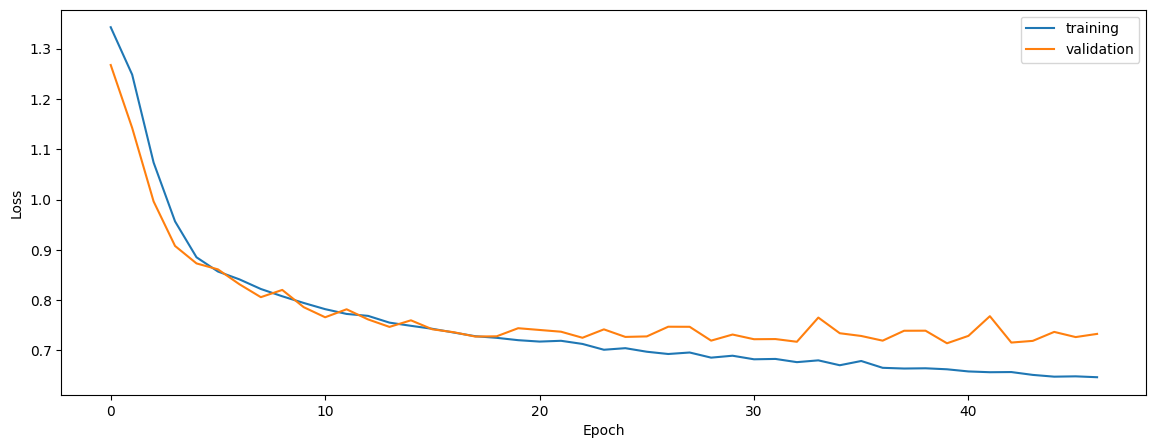

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuracy(train[1],train_pred))
print(getAccuracy(val[1],val_pred))
print(getAccuracy(test[1],test_pred))

train
0.7304209692286978
0.7148190581542352
0.730351508777607


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuracy(train2[1],train_pred2))
print(getAccuracy(val2[1],val_pred2))
print(getAccuracy(test2[1],test_pred2))

normalized
0.7304209692286978
0.7148190581542352
0.730351508777607


In [9]:
print('native')
print(getAccuracy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuracy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuracy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.7260319522655689
0.7239675016926201
0.7325598131151534


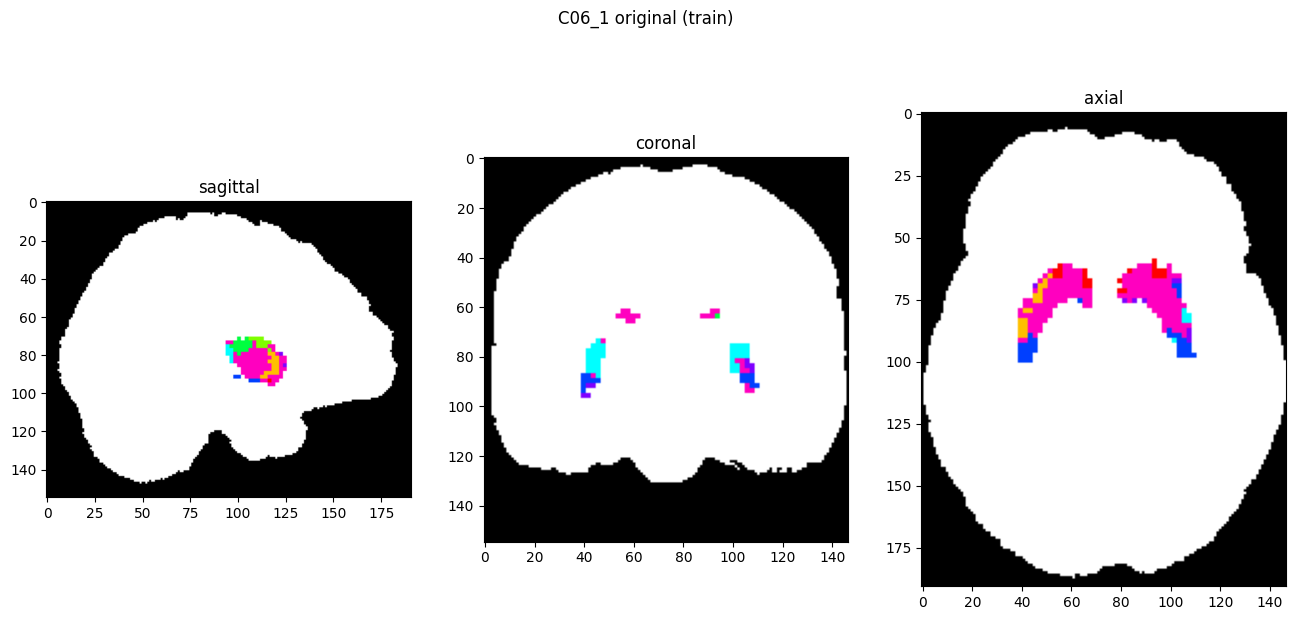

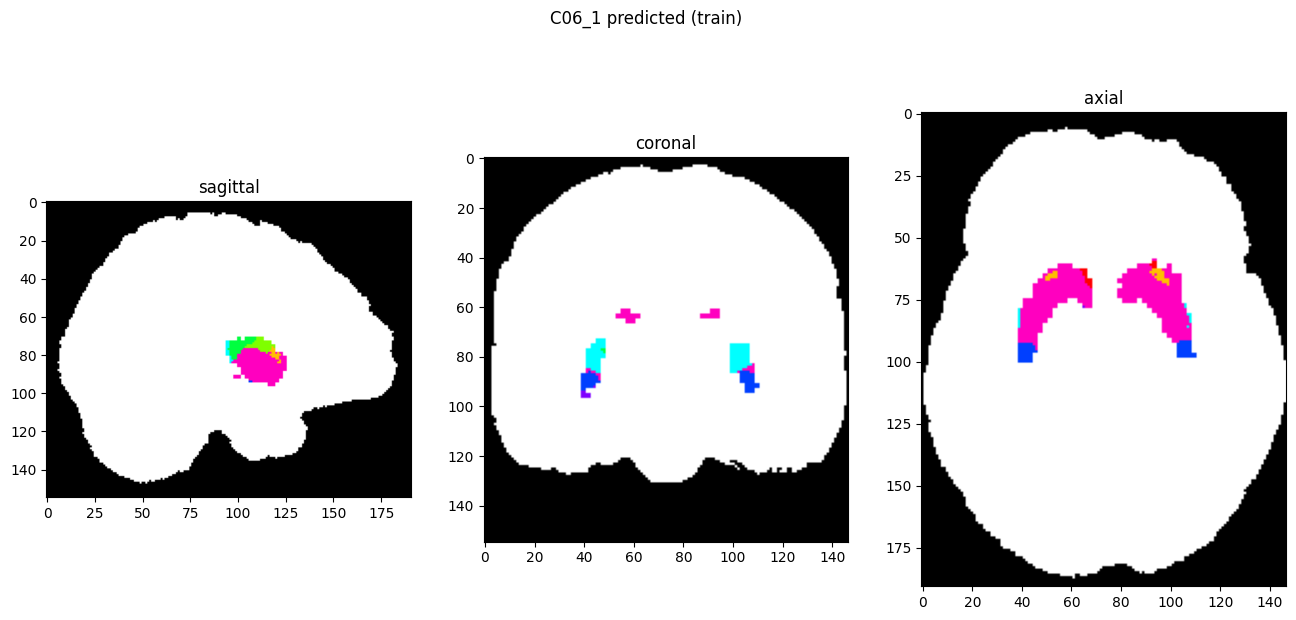

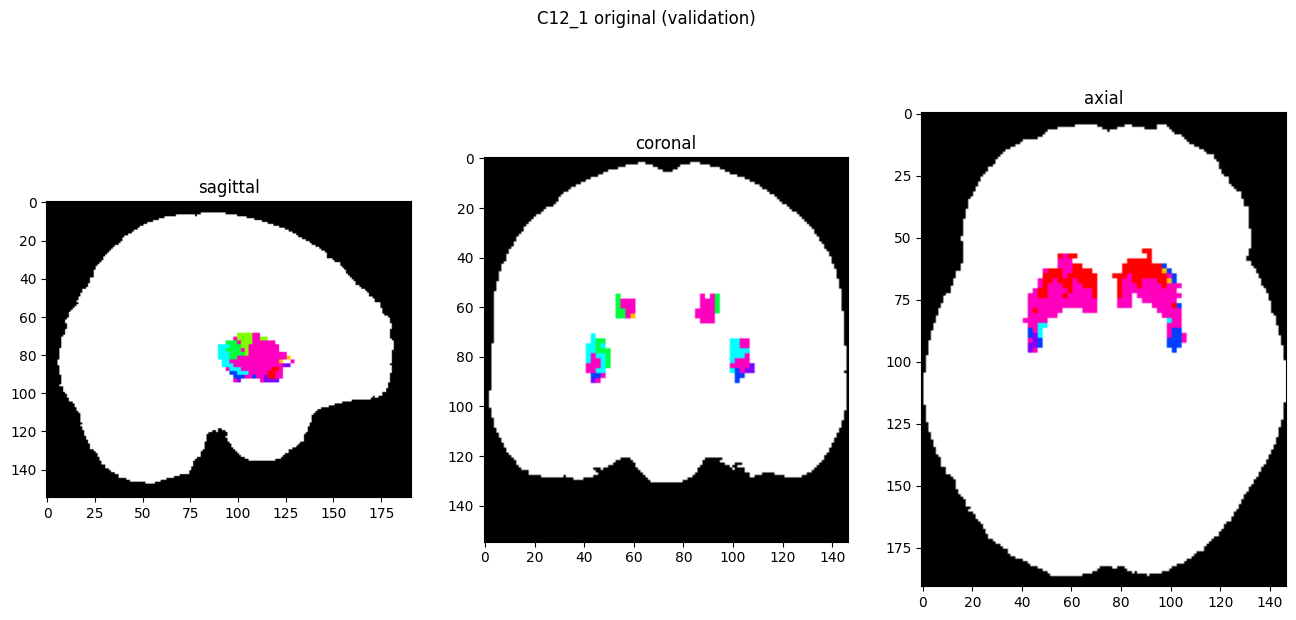

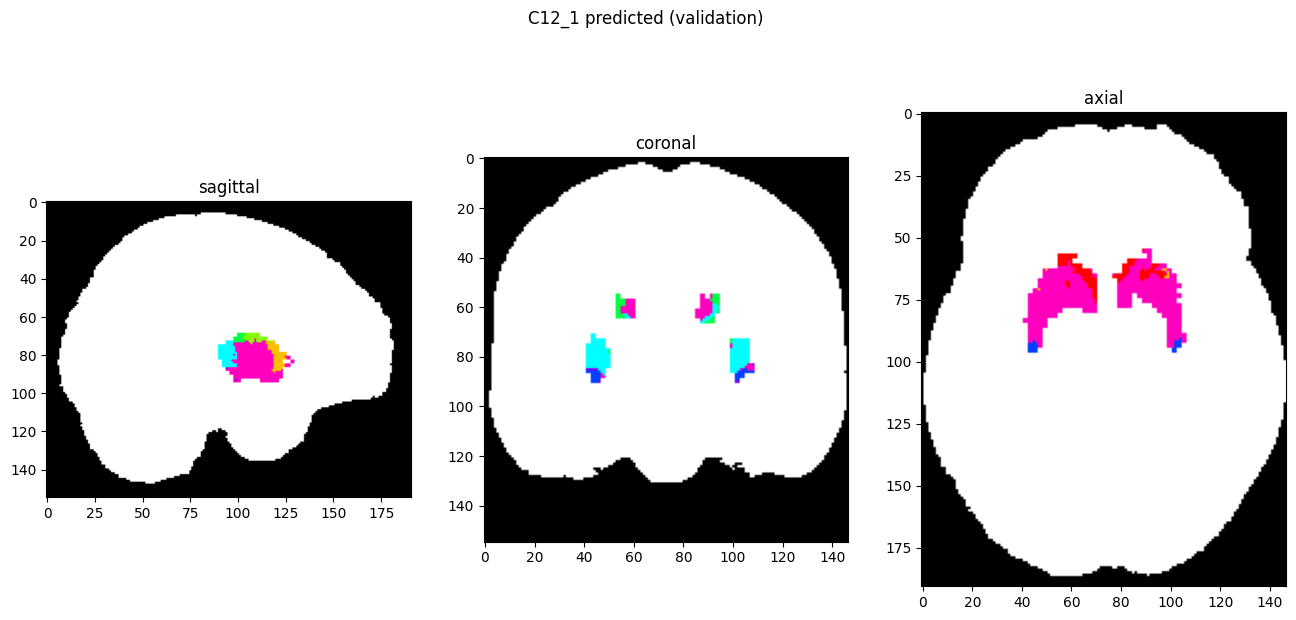

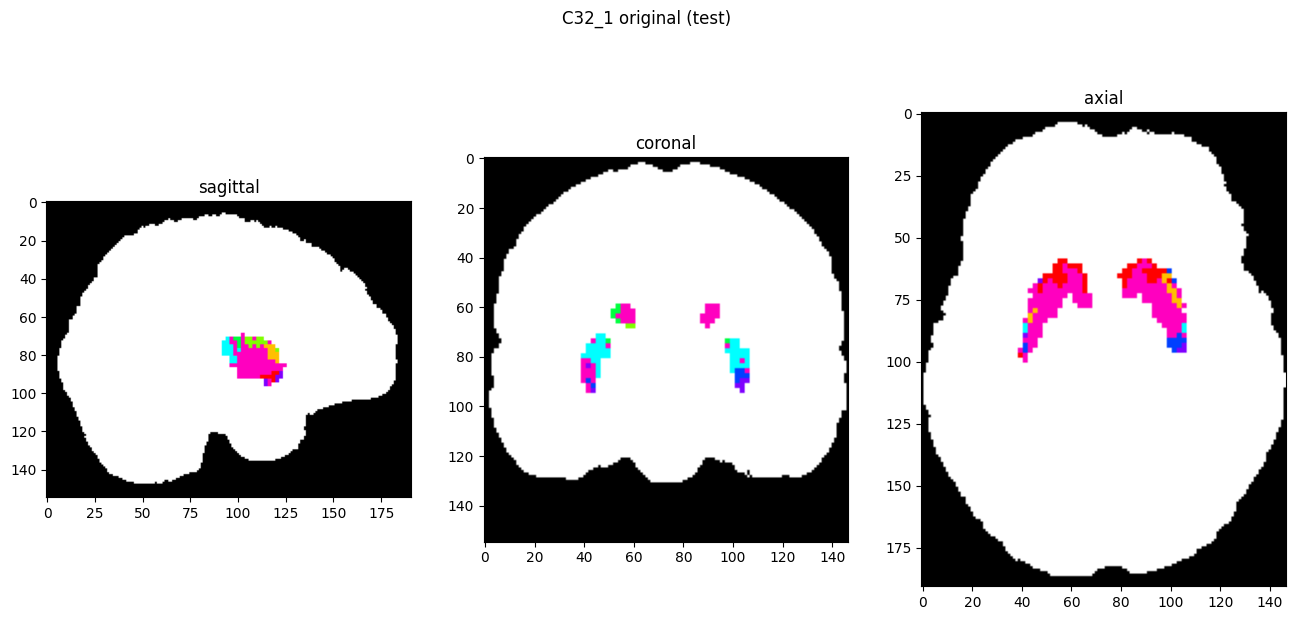

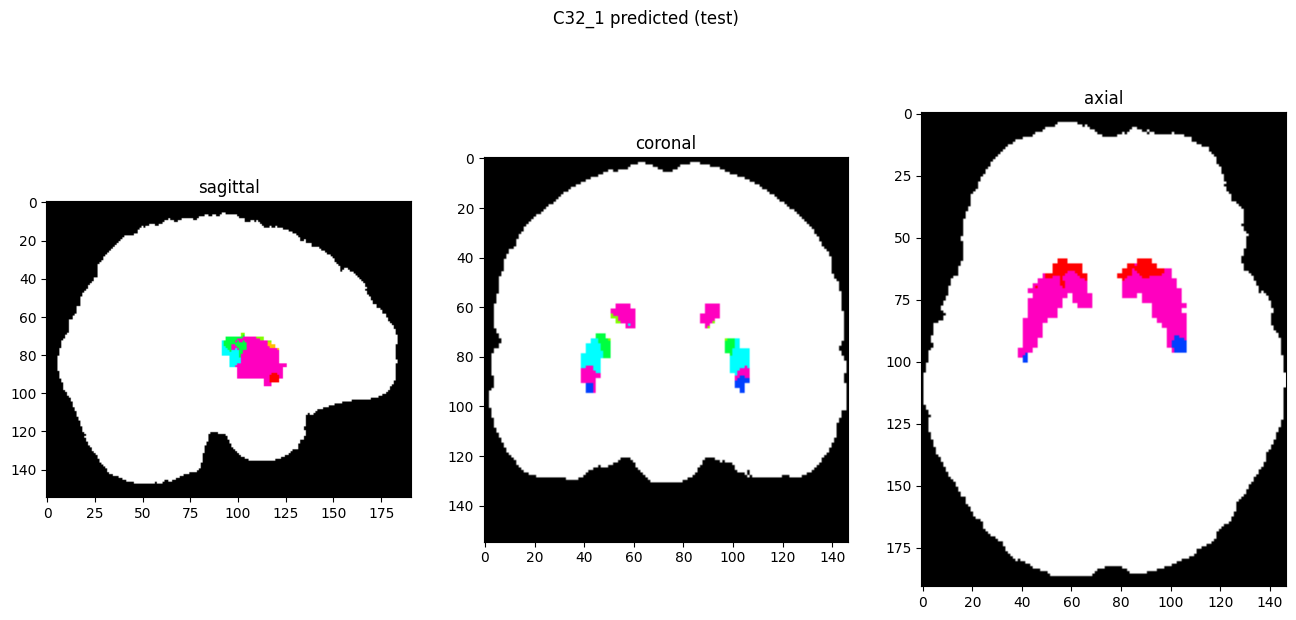

In [10]:
showResults(model, gen, threshold=0)